In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML, Markdown, Latex
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [5]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, ndimage
from scipy.special import factorial
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import itertools
import pickle
import tabulate
import wandb
from collections import defaultdict, deque, namedtuple
import os
import argparse
import atari_py
import torch
import torch.nn.functional as F
import cv2
import colorsys

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [6]:
np.set_printoptions(precision=5)

In [7]:
api = wandb.Api()

In [8]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [9]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')
parser.add_argument('--zero-out-masks-test', action='store_true', help='Test zeroing out particular indices')
parser.add_argument('--zero-out-mask-indices', default=None, help='Which indices to zero out each time')
parser.add_argument('--custom-mask-grouping', type=str, action='append', nargs='+',
                    help='Create custom mask groupings. Provide the name of all masks in a particular group to each invocation of this argument.')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


# Arguments to help with matching then number of parameters between models
parser.add_argument('--conv1-num-filters', default=32, help='Number of filters in first convolutional layer. Default matches the cannonical Rainbow architecture.')
parser.add_argument('--conv2-num-filters', default=64, help='Number of filters in second convolutional layer. Default matches the cannonical Rainbow architecture.')
parser.add_argument('--conv3-num-filters', default=64, help='Number of filters in third convolutional layer. Default matches the cannonical Rainbow architecture.')


_StoreAction(option_strings=['--conv3-num-filters'], dest='conv3_num_filters', nargs=None, const=None, default=64, type=None, choices=None, help='Number of filters in third convolutional layer. Default matches the cannonical Rainbow architecture.', metavar=None)

# Load a run and its model

In [10]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    try:
        run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    except (wandb.CommError, AttributeError) as e:
        return None
    
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, step=None, cache=LOADED_MODEL_CACHE):
    key = (run, step)
    if key not in cache:
        checkpoint_path = download_checkpoint(run, step)
        if checkpoint_path is None:
            return
        
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[key] = dqn, env
        
    return cache[key]


FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\n Wrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')


## Utilities

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE


ModelResults = namedtuple('ModelResults', 
                          ('hidden_states', 'q_values', 'state_values', 'actions'))

KeyIndex = namedtuple('KeyIndex',
                      ('peak_index', 'peak_value', 'start', 'end', 'count', 'indices'))


def rgb_to_grayscale(obs):
    # My best approximation of how the ALE does it
    is_tensor = isinstance(obs, torch.Tensor)
    if is_tensor:
        rgb = obs.type(torch.float32)
    else:
        rgb = obs.astype(np.float32)
        
    gray = rgb[:,:,0] * 0.299 + rgb[:,:,1] * 0.587 + rgb[:,:,2] * 0.114
    
    if is_tensor:
        return gray.type(torch.uint8)
    else:
        return gray.astype(np.uint8)


def observation_to_model(env, obs):
    return env._prepare_state(env._to_tensor(rgb_to_grayscale(obs)), env._to_tensor(obs))


MAX_STATE_IDX = None
SKIP = 2


def pass_states_through_model(model, env, observations, max_state_idx=MAX_STATE_IDX, skip=SKIP):
    state_buffer = deque([], maxlen=4)
    hidden_states = []
    q_values = []
    state_values = []
    actions = []

    for frame in observations[:3]:
        state_buffer.append(observation_to_model(env, frame))

    with torch.no_grad():
        for frame in observations[3:max_state_idx]:
            state_buffer.append(observation_to_model(env, frame))
            state = torch.cat(list(state_buffer), 0)
            
            hidden_state = model.online_net.convs(state.unsqueeze(0)).view(-1)
            hidden_states.append(hidden_state.detach().cpu().numpy())
            
            q_values.append(model.expected_q_values(state))
            state_values.append(model.evaluate_q(state))
            actions.append(model.act(state))

    hidden_state_array = np.array(hidden_states[::skip])
    q_values_array = np.array(q_values[::skip])
    state_value_array = np.array(state_values[::skip])
    action_array = np.array(actions[::skip])
    
    return ModelResults(hidden_state_array, q_values_array, state_value_array, action_array)


def plot_entire_state(observations, start_index, num_frames=4):
    figure = plt.figure(figsize=(18, 4))
    for i in range(num_frames):
        ax = plt.subplot(1, num_frames, i + 1)
        ax.imshow(observations[start_index + i])
        
    plt.show()
    

def plot_embeddings_and_state(embeddings, color_values, observations, start_index, special_indices=None, num_frames=4,
                              low_alpha=0.1, medium_alpha=0.7, alpha_threshold=0.7):
    fig = plt.figure(constrained_layout=True, figsize=(16, 8))
    gs = fig.add_gridspec(2, 4)
    
    tsne_ax = fig.add_subplot(gs[:, :2])
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    normalizer = matplotlib.colors.Normalize(np.min(color_values), np.max(color_values))

    colors = np.array([cmap(normalizer(d)) for d in color_values])
    colors[:,3] = np.abs(color_values) / np.max(np.abs(color_values))
    colors[colors[:,3] > alpha_threshold, 3] = medium_alpha
    colors[colors[:,3] < alpha_threshold, 3] = low_alpha

    mask = np.zeros(Y.shape[0], dtype=bool)
    if special_indices is not None:
        mask[special_indices] = True
        colors[mask, 3] = 1

    tsne_ax.scatter(embeddings[~mask, 0], embeddings[~mask, 1], color=colors[~mask])
    tsne_ax.scatter(embeddings[mask, 0], embeddings[mask, 1], color='purple', s=50, marker='x')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=tsne_ax)
    
    for i in range(num_frames):
        ax = fig.add_subplot(gs[i // 2, 2 + (i % 2)])
        ax.imshow(observations[start_index + i])
        
    plt.show()
    
    
ALE_ACTIONS = {
    0: 'noop',
    1: 'fire',
    2: 'up',
    3: 'right',
    4: 'left',
    5: 'down',
    6: 'up + right',
    7: 'up + left',
    8: 'down + right',
    9: 'down + left',
    10: 'up + fire',
    11: 'right + fire',
    12: 'left + fire',
    13: 'down + fire',
    14: 'up + right + fire',
    15: 'up + left + fire',
    16: 'down + right + fire',
    17: 'down + left + fire'
}


def print_model_state_description(results, name, index, top_k=3):
    value = results.state_values[index]
    action = results.actions[index]
    print(f'{name} had value {value:.3f} => {ALE_ACTIONS[action]} ({action})')
    q = results.q_values[index].cpu().numpy()
    top_actions = np.argpartition(q, -top_k)[-top_k:]
    top_actions = top_actions[np.argsort(q[top_actions])][::-1]
    p = F.softmax(results.q_values[index], dim=0)
    print(' | '.join([f'({i + 1}) {ALE_ACTIONS[a]} [{a}], Q = {q[a]:.3f}, P = {p[a]:.3f}' for i, a in enumerate(top_actions)]))

    
def describe_states_by_indices(indices, first_model_results, first_model_name, second_model_results, second_model_name, 
                               observations, embeddings, color_values, top_k=3, plot_embeddings=False):
    for key_index in sorted(indices, key=lambda ki: ki.peak_index):
        index = key_index.peak_index
        print(f'At index {index}')
        print_model_state_description(first_model_results, first_model_name, index, top_k)
        print_model_state_description(second_model_results, second_model_name, index, top_k)
        
        if plot_embeddings:
            plot_embeddings_and_state(embeddings, color_values, observations, 
                                      key_index.peak_index, 
                                      special_indices=key_index.indices)
        else:
            plot_entire_state(observations, index)
    
    
def find_diverging_states(values, indices, min_distance=10):
    index_values = [values[i] for i in indices]
    output = [KeyIndex(indices[0], index_values[0], indices[0], indices[0], 1, [indices[0]])]
    
    for index, value in zip(indices[1:], index_values[1:]):
        current = output[-1]
        
        # Sufficiently far away, append a new one
        if index > current.end + min_distance:
            output.append(KeyIndex(index, value, index, index, 1, [index]))
            
        # Value more extreme, replace peak
        elif abs(value) > abs(current.peak_value):  
            output[-1] = KeyIndex(index, value, current.start, index, current.count + 1, current.indices + [index])
            
        # Value not more extreme, extend
        else:
            output[-1] = KeyIndex(current.peak_index, current.peak_value, current.start, index, current.count + 1, current.indices + [index])
            
    return output

# Gameplan

1. See that I can locate objects
2. See that I can add additional objects
3. See what this changes

# Scratch

Using model 306 from the baseline condition, one of the average models, not the 'superstar' one

In [12]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)

(5671, 210, 160, 3)


In [ ]:
baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)

In [ ]:
baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

baseline_model_results.hidden_states.shape

In [ ]:
tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(baseline_model_results.hidden_states)
Y.shape

In [ ]:
masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run)
masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

In [ ]:
for x in DEFAULT_MASK_NAMES[1:]:
    print(x.replace('_', ' ').title())

In [ ]:
frame_idx = 1230
obs = sample_full_color_observations[frame_idx]
state = observation_to_model(masks_only_env, sample_full_color_observations[frame_idx]).cpu().numpy()

plt.figure(figsize=(12, 12.75))
plt.subplots_adjust(hspace=0.075, wspace=0.075)

pixels_ax = plt.subplot(3, 3, 1)
pixels_ax.imshow(cv2.resize(obs, (160, 160), interpolation=cv2.INTER_LINEAR))
pixels_ax.set_title('Pixels', fontsize=20)
pixels_ax.xaxis.set_major_locator(plt.NullLocator())
pixels_ax.yaxis.set_major_locator(plt.NullLocator())

for i, name in enumerate(DEFAULT_MASK_NAMES[1:]):
    ax = plt.subplot(3, 3, i + 2)
    ax.imshow(state[i], cmap='Greys')
    ax.set_title(name.replace('_', ' ').title(), fontsize=20)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    

save('mask_examples.pdf')
plt.show()



In [ ]:
frame_idx = 1230
obs = sample_full_color_observations[frame_idx]
# state = observation_to_model(masks_only_env, sample_full_color_observations[frame_idx]).cpu().numpy()
state = masks_only_env.masker(torch.tensor(sample_full_color_observations[frame_idx]).to(masks_only_env.device)).cpu().numpy()

plt.figure(figsize=(8, 11))
plt.subplots_adjust(hspace=0.1, wspace=0.1)

pixels_ax = plt.subplot(3, 3, 1)
# pixels_ax.imshow(cv2.resize(obs, (160, 160), interpolation=cv2.INTER_LINEAR))
pixels_ax.imshow(obs)
pixels_ax.set_title('Pixels', fontsize=16)
pixels_ax.xaxis.set_major_locator(plt.NullLocator())
pixels_ax.yaxis.set_major_locator(plt.NullLocator())

for i, name in enumerate(DEFAULT_MASK_NAMES[1:]):
    ax = plt.subplot(3, 3, i + 2)
    ax.imshow(state[i], cmap='Greys')
    ax.set_title(name.replace('_', ' ').title(), fontsize=16)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    

save('mask_examples_original_res.pdf')
plt.show()



----------

-----------

# More organized take at this code

In [12]:
ChannelAugmentation = namedtuple('ChannelAugmentation', 
                                 ('channel_index', 'added_object', 'added_location'))

ModelAugmentation = namedtuple('ModelAugmentation', 
                               ('name', 'model', 'env', 'pixel_augmentations', 'mask_augmentations'))


def augment_pixels(state, pixel_augmentation, shift=None):
    if shift is None:
        shift = (0, 0)
        
    dst_slices = [slice(pixel_augmentation.added_location[i] + shift[i], 
                        pixel_augmentation.added_location[i] + shift[i] + pixel_augmentation.added_object.shape[i])
                  for i in range(len(pixel_augmentation.added_location))] 
    
    state[dst_slices[0], dst_slices[1], :] = pixel_augmentation.added_object
    return state


def augment_mask_channel(state, channel_augmentation, shift=None):
    if shift is None:
        shift = (0, 0)
        
    dst_slices = [slice(channel_augmentation.added_location[i] + shift[i],
                        channel_augmentation.added_location[i] + shift[i] + channel_augmentation.added_object.shape[i])
                  for i in range(len(channel_augmentation.added_location))] 
    state[channel_augmentation.channel_index, dst_slices[0], dst_slices[1]] = channel_augmentation.added_object
    return state
    

def modify_observation_to_model_state(obs, model_augmentation, shift=None, return_pixels=False):
    # pixel augmentations if any exist
    obs_tensor = model_augmentation.env._to_tensor(obs)
    if model_augmentation.pixel_augmentations is not None:
        for pixel_aug in model_augmentation.pixel_augmentations:
            obs_tensor = augment_pixels(obs_tensor, pixel_aug, shift=shift)
    
    # take this tensor and drop it to grayscale and low-res
    gray_obs_tensor = rgb_to_grayscale(obs_tensor)
    
    masks = None
    
    # create masks for this model
    if hasattr(model_augmentation.env, 'masker'):
        masks = model_augmentation.env.masker(model_augmentation.env._to_tensor(obs))
    
        # mask augmentations if any exist
        if model_augmentation.mask_augmentations is not None:
            for augmentation in model_augmentation.mask_augmentations:
                masks = augment_mask_channel(masks, augmentation, shift=shift)
                
        masks = model_augmentation.env._resize(masks.unsqueeze(0))
        
    # TODO: delete me
#     if masks is not None:
#         plt.figure(figsize=(12, 12.75))
#         plt.subplots_adjust(hspace=0.075, wspace=0.075)

#         pixels_ax = plt.subplot(3, 3, 1)
#         pixels_ax.imshow(cv2.resize(obs_tensor.cpu().numpy().astype(np.uint8), (160, 160), interpolation=cv2.INTER_LINEAR))
#         pixels_ax.set_title('Pixels', fontsize=16)
#         pixels_ax.xaxis.set_major_locator(plt.NullLocator())
#         pixels_ax.yaxis.set_major_locator(plt.NullLocator())

#         for i, name in enumerate(DEFAULT_MASK_NAMES[1:]):
#             ax = plt.subplot(3, 3, i + 2)
#             ax.imshow(masks[0, i].cpu().numpy(), cmap='Greys')
#             ax.set_title(name.replace('_', ' ').title(), fontsize=16)
#             ax.xaxis.set_major_locator(plt.NullLocator())
#             ax.yaxis.set_major_locator(plt.NullLocator())
            
#         plt.show()
    
    # combine (handles resizing of the raw observation)
    final_state = model_augmentation.env._prepare_state(gray_obs_tensor.type(torch.float32), None, masks)
    
    if return_pixels is True:
        return final_state, obs_tensor.type(torch.uint8)
#     
    return final_state


def augmented_state_q_values(observations, augmented_index, model_augmentations, state_length=4, 
                             return_before_and_after=False, return_variance=False, augment_all_frames=False,
                             augmentation_previous_frame_shift=None):
    if augmented_index < state_length - 1 or augmented_index >= len(observations):
        raise ValueError(f'Augmented index should be in [{state_length - 1}, {len(observations)}), received {augmented_index}')

    before_q_values_per_model = []
    before_q_variances_per_model = []
    after_q_values_per_model = []
    after_q_variances_per_model = []
    before_pixels, after_pixels, all_pixels = None, None, []
    plotted = False
    
    for model_augmentation in model_augmentations:
        # TODO: verify I don't have an off-by-one here
        state_buffer = [observation_to_model(model_augmentation.env, obs) 
                        for obs in observations[augmented_index - state_length + 1:augmented_index + 1]]
        
#         if return_before_and_after and before_pixels is None:
        if before_pixels is None:
            before_pixels = observations[augmented_index]
            all_pixels.insert(0, before_pixels)
        
        model_ready_state = torch.cat(list(state_buffer), 0)
        if return_variance:
            mean, variance = model_augmentation.model.q_value_mean_variance(model_ready_state)
            before_q_values_per_model.append(mean)
            before_q_variances_per_model.append(variance)
        else:
            before_q_values_per_model.append(model_augmentation.model.expected_q_values(model_ready_state))

#         if return_before_and_after and after_pixels is None:
        if after_pixels is None:
            augmented_state, after_pixels_tensor = modify_observation_to_model_state(observations[augmented_index], 
                                                                                     model_augmentation, return_pixels=True)
            after_pixels = after_pixels_tensor.cpu().numpy()
            
            
        else:
            augmented_state = modify_observation_to_model_state(observations[augmented_index], model_augmentation)
            
        state_buffer[-1] = augmented_state
        
        if augment_all_frames:
            for i in range(state_length - 1):
                shift = None
                if augmentation_previous_frame_shift is not None:
                    shift = [(state_length - 1 - i) * dim_shift for dim_shift in augmentation_previous_frame_shift]
                    
#                 if plotted is False and model_augmentation.name == 'Masks+Pixels': 
#                     print(i, 'Shift', shift)
                state_buffer[i], next_pixels_tensor = modify_observation_to_model_state(observations[augmented_index - state_length + 1 + i], 
                                                                                        model_augmentation, shift, return_pixels=True)
                all_pixels.append(next_pixels_tensor.cpu().numpy())
                
            all_pixels.append(after_pixels)
                
#             if augmentation_previous_frame_shift is not None and not plotted and model_augmentation.name == 'Masks+Pixels':
#                 print('State length', state_length, 'all_pixels', len(all_pixels))
#                 print([px.dtype for px in all_pixels])
#                 plotted = True
#                 plot_observations_by_indices(all_pixels, range(len(all_pixels)))
#                 pix_diff = [all_pixels[i + 1] - all_pixels[i] for i in range(len(all_pixels) - 1)]
#                 plot_observations_by_indices(pix_diff, range(len(pix_diff)))
                
        model_ready_state = torch.cat(list(state_buffer), 0)
        
        if return_variance:
            mean, variance = model_augmentation.model.q_value_mean_variance(model_ready_state)
            after_q_values_per_model.append(mean)
            after_q_variances_per_model.append(variance)
        else:
            after_q_values_per_model.append(model_augmentation.model.expected_q_values(model_ready_state))

    ret_val = [before_q_values_per_model, after_q_values_per_model]
    
    if return_variance:
        ret_val.extend((before_q_variances_per_model, after_q_variances_per_model))
        
    if return_before_and_after:
        ret_val.extend((before_pixels, after_pixels))
    
    return ret_val


def max_wrapper(tensor, axis=0):
    val, idx = tensor.max(axis)
    return float(val), int(idx)


def evaluate_augmented_models(observations, augmented_index, model_augmentations, state_length=4,
                              before_color='red', after_color='blue', bar_alpha=0.5,
                              bar_width=0.8, fontdict=dict(fontsize=16), force_text=None, text_epsilon=0,
                              plot_state=True):
    if plot_state:
        fig = plt.figure(constrained_layout=True, figsize=(8 * len(model_augmentations) + 1, 6))
        gs = fig.add_gridspec(2, 7)
        before_q_values_per_model, after_q_values_per_model, before_state, after_state = augmented_state_q_values(observations, 
            augmented_index, model_augmentations, state_length=state_length, return_before_and_after=True)

        before_ax = fig.add_subplot(gs[0, 0])
        if len(before_state.shape) == 3:
            before_ax.imshow(before_state)
        else:
            before_ax.imshow(before_state, cmap='gray')
        before_ax.set_title('Before')
        
        after_ax = fig.add_subplot(gs[1, 0])
        if len(after_state.shape) == 3:
            after_ax.imshow(after_state)
        else:
            after_ax.imshow(after_state, cmap='gray')
        after_ax.set_title('After')
    
    else:
        plt.figure(figsize=(8 * len(model_augmentations), 6))
        before_q_values_per_model, after_q_values_per_model = augmented_state_q_values(observations, augmented_index, 
                                                                                       model_augmentations, state_length=state_length)

    

    for i, (model_augmentation, before_q, after_q) in enumerate(zip(model_augmentations, 
                                                                                       before_q_values_per_model, after_q_values_per_model, 
                                                                                      )):
        print(f'For model {model_augmentation.name}:')
        before_mean, after_mean = before_q.mean().cpu().numpy(), after_q.mean().cpu().numpy()
        before_v, after_v = before_q.max().cpu().numpy(), after_q.max().cpu().numpy()
        print(f'Baseline mean: {before_mean:.3f} | Augmented mean: {after_mean:.3f} | Difference: {after_mean - before_mean:.3f}')
        
        diff = after_q - before_q
        max_diff, max_diff_idx = max_wrapper(diff.abs())
        print(f'Max Q value diff is {max_diff:.3f} for action {ALE_ACTIONS[max_diff_idx]} [{max_diff_idx}]')

        if plot_state:
            ax = fig.add_subplot(gs[:, 1 + 2 * i :1 + 2 * (i + 1)])
        else:
            ax = plt.subplot(1, len(model_augmentations), i + 1)
        
        locations = np.arange(before_q.shape[0]) * bar_width * 2.5
        ax.bar(locations, before_q.cpu().numpy(), color=before_color, alpha=bar_alpha)
        ax.bar(locations + bar_width, after_q.cpu().numpy(), color=after_color, alpha=bar_alpha)
        ax.hlines([before_mean, after_mean], *ax.get_xlim(), colors=[before_color, after_color],
                  linestyles='dashed')
        
        ax.hlines([before_v, after_v], *ax.get_xlim(), colors=[before_color, after_color],
                  linestyles='dotted')
        
        text_fd = {k:fontdict[k] for k in fontdict}
        ax.text(locations[max_diff_idx] + bar_width / 2, max(before_q[max_diff_idx], after_q[max_diff_idx]) + text_epsilon,
                '*', fontdict=text_fd)
        
        before_action_q, before_action_idx = max_wrapper(before_q)
        after_action_q, after_action_idx = max_wrapper(after_q)
        
        print(f'Before action: {ALE_ACTIONS[before_action_idx]} [{before_action_idx}] (Q = {before_action_q:.3f}) | After action: {ALE_ACTIONS[after_action_idx]} [{after_action_idx}] (Q = {after_action_q:.3f})')
        
        if before_action_idx != after_action_idx or (force_text is not None and force_text):
            text_fd['color'] = before_color
            ax.text(locations[before_action_idx] - (bar_width / 2), before_action_q + text_epsilon, 'B', fontdict=text_fd)

            text_fd['color'] = after_color
            ax.text(locations[after_action_idx] + (bar_width / 2), after_action_q + text_epsilon, 'A', fontdict=text_fd)
        
        ax.set_xticks(locations + (bar_width / 2))
        ax.set_xticklabels(sorted(ALE_ACTIONS.keys()))
        
        ax.set_xlabel('Action Index', fontdict=fontdict)
        ax.set_ylabel('Q Value', fontdict=fontdict)
        ax.set_title(model_augmentation.name, fontdict=fontdict)
        print()

    plt.show()


def evaluate_multiple_models_single_augmented_state(observations, augmented_index, model_augmentations_per_group,
                                                    key_actions=None, key_actions_aggregator_func=lambda t: t.mean(axis=1), 
                                                    state_length=4,
                                                    before_color='red', after_color='blue', 
                                                    bar_alpha=0.5, bar_width=0.8, 
                                                    fontdict=dict(fontsize=16), force_text=None, 
                                                    text_epsilon=0, plot_state=True, plot_variance=False,
                                                    state_value_title='State values',
                                                    key_action_title='Key action Q-values',
                                                    names=None, save_name=None, ylim=(-0.5, 10.5)):
    # TODO: if using multiple states or models, we need to average properly over the before_q / after_q tensors
    # That is, compute the average mean difference and the average max difference
    # The per-action bar charts might make less sense?
    # If we do this, we can plot a histogram of MMeanD and MMaxD and over the different random seeds (for one state)
    # Or the different states for one (or more) random seeds
    
    plot_key_actions = key_actions is not None
    num_panels = 1 + int(plot_state) + int(plot_key_actions)
    constrained_layout = plot_state
    fig = plt.figure(constrained_layout=constrained_layout, figsize=(8 * num_panels, 6))
    
    if plot_state:
        gs = fig.add_gridspec(1, num_panels * 2)
        _, _, before_state, after_state = augmented_state_q_values(observations, 
            augmented_index, [model_augmentations_per_group[0][0]], state_length=state_length, return_before_and_after=True)

        before_ax = fig.add_subplot(gs[0, 0])
        if len(before_state.shape) == 3:
            before_ax.imshow(before_state)
        else:
            before_ax.imshow(before_state, cmap='gray')
        before_ax.xaxis.set_major_locator(plt.NullLocator())
        before_ax.yaxis.set_major_locator(plt.NullLocator())
        before_ax.set_title('Before', fontdict=fontdict)
        
        after_ax = fig.add_subplot(gs[0, 1])
        if len(after_state.shape) == 3:
            after_ax.imshow(after_state)
        else:
            after_ax.imshow(after_state, cmap='gray')
        after_ax.xaxis.set_major_locator(plt.NullLocator())
        after_ax.yaxis.set_major_locator(plt.NullLocator())
        after_ax.set_title('After', fontdict=fontdict)
    
    if plot_state:
        state_value_ax = fig.add_subplot(gs[0, 2:4])
        if plot_key_actions:
            key_actions_ax = fig.add_subplot(gs[0, 4:])
    else:
        state_value_ax = plt.subplot(1, num_panels, 1)
        if plot_key_actions:
            key_actions_ax = plt.subplot(1, 2, 2)
    
    all_state_values_before = []
    all_state_values_after = []
    
    if plot_variance:
        all_state_variances_before = []
        all_state_variances_after = []
    
    if plot_key_actions:
        all_key_action_values_before = []
        all_key_action_values_after = []
        
        all_key_action_variances_before = []
        all_key_action_variances_after = []
        
    if names is None:
        names = [aug_group[0].name for aug_group in model_augmentations_per_group]
    
    for model_augmentations in model_augmentations_per_group:
        if plot_variance:
            q_values_before, q_values_after, q_variances_before, q_variances_after = augmented_state_q_values(observations, augmented_index, model_augmentations, 
                                                                                                              state_length=state_length, return_variance=plot_variance)
        else:
            q_values_before, q_values_after = augmented_state_q_values(observations, augmented_index, model_augmentations, 
                                                                                                              state_length=state_length, return_variance=plot_variance)
        q_values_before = torch.stack(q_values_before)
        q_values_after = torch.stack(q_values_after)
        
        if plot_variance:
            q_variances_before = torch.stack(q_variances_before)
            q_variances_after = torch.stack(q_variances_after)
        
        state_values_before, before_max_indices = q_values_before.max(1)
        state_values_after, after_max_indices = q_values_after.max(1)
        
        all_state_values_before.append(state_values_before.cpu().numpy())
        all_state_values_after.append(state_values_after.cpu().numpy())
        
        if plot_variance:
            all_state_variances_before.append(q_variances_before.gather(1, before_max_indices.unsqueeze(1)).squeeze().cpu().numpy())
            all_state_variances_after.append(q_variances_after.gather(1, after_max_indices.unsqueeze(1)).squeeze().cpu().numpy())
        
        if plot_key_actions:
            all_key_action_values_before.append(key_actions_aggregator_func(q_values_before[:, key_actions]).cpu().numpy())
            all_key_action_values_after.append(key_actions_aggregator_func(q_values_after[:, key_actions]).cpu().numpy())
            
            all_key_action_variances_before.append(key_actions_aggregator_func(q_variances_before[:, key_actions]).cpu().numpy())
            all_key_action_variances_after.append(key_actions_aggregator_func(q_variances_after[:, key_actions]).cpu().numpy())
            
    for name, before, after in zip(names, all_state_values_before, all_state_values_after):
        print(f'(A) For model {name} | Before mean = {np.mean(before):.3f}, median = {np.median(before):.3f} | After mean = {np.mean(after):.3f}, median = {np.median(after):.3f} ')
                
    before_plot_values = [all_state_values_before, ] 
    after_plot_values = [all_state_values_after, ] 
    
    if plot_variance:
        before_plot_values.append(all_state_variances_before)
        after_plot_values.append(all_state_variances_after)
        
    create_box_plot_set(state_value_ax, before_plot_values, after_plot_values, names,
                        before_color, after_color, 'Model Type', 'V(s)', state_value_title, 
                        fontdict, (None, dict(linestyle='dashed')))
    
    if plot_key_actions:
        create_box_plot_set(key_actions_ax, 
                            [all_key_action_values_before, all_key_action_variances_before], 
                            [all_key_action_values_after, all_key_action_variances_after], names,
                            before_color, after_color, 'Model Type', 'Q(s, a)', key_action_title, 
                            fontdict, (None, dict(linestyle='dashed')))
        
    if save_name is not None:
        save(save_name)
    
    plt.show()
    

def create_box_plot_set(ax, value_sets_before, value_sets_after, names, before_color, after_color,
                        x_label, y_label, title, fontdict, additional_boxplot_properties=None):
    
    if additional_boxplot_properties is None:
        additional_boxplot_properties = [None] * len(value_sets_before)
    
    before_positions = np.arange(len(names)) * 2 * len(value_sets_before)
    after_positions = before_positions + len(value_sets_before)
    
    for i, (values_before, values_after, boxplot_props) in enumerate(zip(value_sets_before, 
                                                                         value_sets_after, 
                                                                         additional_boxplot_properties)):
        if boxplot_props is None:
            boxplot_props = {}
    
        ax.boxplot(np.array(values_before).T, positions=before_positions + i, 
                   boxprops=dict(color=before_color, **boxplot_props), 
                   whiskerprops=dict(color=before_color, **boxplot_props),
                   capprops=dict(color=before_color, **boxplot_props),
                   medianprops=boxplot_props)
        ax.boxplot(np.array(values_after).T, positions=after_positions + i, 
                   boxprops=dict(color=after_color, **boxplot_props), 
                   whiskerprops=dict(color=after_color, **boxplot_props),
                   capprops=dict(color=after_color, **boxplot_props), 
                   medianprops=boxplot_props)

    dashed_line_positions = (before_positions - .5)[1:]
    if ylim is None:
        ylim = ax.get_ylim()
    ax.vlines(dashed_line_positions, *ylim, colors='gray', linestyles='dashed')

    xtick_positions = np.concatenate([before_positions, after_positions]) + 0.5 * (len(value_sets_before) - 1)
    xtick_labels = [f'{name}\nBefore' for name in names] + [f'{name}\nAfter' for name in names]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)

    ax.set_xlabel(x_label, fontdict=fontdict)
    ax.set_ylabel(y_label, fontdict=fontdict)
    ax.set_title(title, fontdict=fontdict)
    


In [117]:
def multiple_models_single_augmented_state_single_plot(observations, augmented_index, model_augmentations_per_group,
                                                       colors, after_ax, values_ax, after_value_positions, median_color,
                                                       before_ax=None, before_value_positions=None, additional_boxplot_properties=None,
                                                       state_length=4, before_title='Before', after_title='After', names=None,
                                                       major_fontdict=dict(fontsize=24), minor_fontdict=dict(fontsize=16),
                                                       augment_all_frames=False, augmentation_previous_frame_shift=None):
    
    if before_ax is not None and before_value_positions is None:
        raise ValueError('Must supply `before_value_positions` when supplying `before_ax`')
    
    _, _, before_state, after_state = augmented_state_q_values(observations, 
        augmented_index, [model_augmentations_per_group[0][0]], state_length=state_length, return_before_and_after=True)

    if before_ax is not None:
        if len(before_state.shape) == 3:
            before_ax.imshow(before_state)
        else:
            before_ax.imshow(before_state, cmap='gray')
        before_ax.xaxis.set_major_locator(plt.NullLocator())
        before_ax.yaxis.set_major_locator(plt.NullLocator())
        before_ax.set_title(before_title, fontdict=major_fontdict)
        
    if len(after_state.shape) == 3:
        after_ax.imshow(after_state)
    else:
        after_ax.imshow(after_state, cmap='gray')
    after_ax.xaxis.set_major_locator(plt.NullLocator())
    after_ax.yaxis.set_major_locator(plt.NullLocator())
    after_ax.set_title(after_title, fontdict=major_fontdict)
    
    all_state_values_before = []
    all_state_values_after = []
        
    
    for model_augmentations in model_augmentations_per_group:
        q_values_before, q_values_after = augmented_state_q_values(observations, augmented_index, model_augmentations, 
                                                                   state_length=state_length, return_variance=False,
                                                                   augment_all_frames=augment_all_frames,
                                                                   augmentation_previous_frame_shift=augmentation_previous_frame_shift)
        q_values_before = torch.stack(q_values_before)
        q_values_after = torch.stack(q_values_after)
        
        state_values_before, before_max_indices = q_values_before.max(1)
        state_values_after, after_max_indices = q_values_after.max(1)
        
        all_state_values_before.append(state_values_before.cpu().numpy())
        all_state_values_after.append(state_values_after.cpu().numpy())
        
    if names is None:
        names = [aug_group[0].name for aug_group in model_augmentations_per_group]
      
    for name, before, after in zip(names, all_state_values_before, all_state_values_after):
        print(f'For model {name} | Before mean = {np.mean(before):.3f}, median = {np.median(before):.3f} | After mean = {np.mean(after):.3f}, median = {np.median(after):.3f} ')
        
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            first_name = names[i]
            first_after_values = all_state_values_after[i]
            
            second_name = names[j]
            second_after_values = all_state_values_after[j]
            
            t, p = stats.ttest_ind(first_after_values, second_after_values)
            print(f'For models {first_name} and {second_name}, t = {t:.3f} => P = {p:.3f}{"*" if p <= 0.05 else ""}{"*" if p <= 0.01 else ""} (n = {len(first_after_values)})')
        
    
    if before_value_positions is not None:
        add_boxplots_to_ax(values_ax, all_state_values_before, before_value_positions,
                           names, colors, minor_fontdict, median_color, additional_boxplot_properties)
        
    add_boxplots_to_ax(values_ax, all_state_values_after, after_value_positions,
                       names, colors, minor_fontdict, median_color, additional_boxplot_properties)
                  
    return all_state_values_before, all_state_values_after

    

def add_boxplots_to_ax(ax, value_sets, positions, names, colors, fontdict, median_color,
                       additional_boxplot_properties=None):
    
    if additional_boxplot_properties is None:
        additional_boxplot_properties = [dict(lw=2)] * len(positions)
    
    for i, (values, position, name, color, boxplot_props) in enumerate(zip(value_sets, positions, names, colors, additional_boxplot_properties)):

        ax.boxplot(np.array(values).T, positions=[position], widths=0.5,
                   boxprops=dict(color=color, **boxplot_props), 
                   whiskerprops=dict(color=color, **boxplot_props),
                   capprops=dict(color=color, **boxplot_props),
                   medianprops=dict(color=median_color, **boxplot_props))

#     dashed_line_positions = (before_positions - .5)[1:]
#     ax.vlines(dashed_line_positions, *ax.get_ylim(), colors='gray', linestyles='dashed')

    ax.set_xticks(np.concatenate((ax.get_xticks(), positions)))
    ax.set_xticklabels(ax.get_xticklabels() + list(names), **fontdict)

#     ax.set_xlabel(x_label, fontdict=fontdict)
#     ax.set_ylabel(y_label, fontdict=fontdict)
#     ax.set_title(title, fontdict=fontdict)

In [14]:
DIAGONAL_CONNECTIVITY_STRUCTURE = ndimage.generate_binary_structure(2, 2)


def to_tensor(numpy_arr, model):
    return torch.Tensor(numpy_arr).to(model.online_net.convs[0].weight.device)


def extract_raw_pixels_object(observations, obs_index, model, env, loc):
    obs = observations[obs_index]
    return env._to_tensor(obs[loc[0], loc[1], :])
#     model_ready_obs = to_tensor(observation_to_model(env, observations[obs_index]).cpu().numpy(), model)
#     return model_ready_obs.squeeze()[loc]


def extract_object(observations, obs_index, model, env, channel_index, 
                   object_index=0, structure=DIAGONAL_CONNECTIVITY_STRUCTURE,
                   return_tensor=True, return_location=False):
#     state = observation_to_model(env, observations[obs_index]).cpu().numpy()
    state = env.masker(env._to_tensor(observations[obs_index])).cpu().numpy()
    labeled, count = ndimage.label(state[channel_index], structure)
    locations = ndimage.find_objects(labeled, 0)
    loc = locations[object_index]
    
    object_arr = state[channel_index, loc[0], loc[1]]
    if return_tensor:
        object_arr = to_tensor(object_arr, model)
        
    if not return_location:
        return object_arr
    
    return object_arr, loc
    

def copy_model_augmentation(model_augmentation, name=None, model=None, env=None, 
                            pixel_augmentations=None, mask_augmentations=None):
    if name is None:
        name = model_augmentation.name
    
    if model is None:
        model = model_augmentation.model
        
    if env is None:
        env = model_augmentation.env
    
    if pixel_augmentations is None:
        pixel_augmentations = model_augmentation.pixel_augmentations
        
    if mask_augmentations is None:
        mask_augmentations = model_augmentation.mask_augmentations
        
    return ModelAugmentation(name, model, env, pixel_augmentations, mask_augmentations)


DEFAULT_GROUPED_OBJECTS_INDICES = (0, 1, 3, 4, 5, 6)


def make_augmentations_all_models(b_aug, m_p_aug, m_o_aug, g_o_aug, pixels_tensor, mask_tensor, mask_channel_index, locations,
                                  g_o_indices=DEFAULT_GROUPED_OBJECTS_INDICES):
    pixel_augs = [ChannelAugmentation(0, pixels_tensor, loc) for loc in locations]
    mask_augs = [ChannelAugmentation(mask_channel_index, mask_tensor, loc) for loc in locations]
    grouped_mask_augs = None
    if mask_channel_index in g_o_indices:
        grouped_mask_augs = [ChannelAugmentation(0, mask_tensor, loc) for loc in locations]
    
    return copy_model_augmentation(b_aug, pixel_augmentations=pixel_augs),\
        copy_model_augmentation(m_p_aug, pixel_augmentations=pixel_augs, mask_augmentations=mask_augs),\
        copy_model_augmentation(m_o_aug, mask_augmentations=mask_augs),\
        copy_model_augmentation(g_o_aug, pixel_augmentations=pixel_augs, mask_augmentations=grouped_mask_augs)


def plot_tensors(*tensors, norm=False):
    normalizer = None
    if norm:
        normalizer = matplotlib.colors.Normalize(0, 1)
    
    n = len(tensors)
    plt.figure(figsize=(4 * n, 4))
    for i, tensor in enumerate(tensors):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(tensors[i].cpu().numpy(), cmap='gray', norm=normalizer)
    
    plt.show()

    
def plot_observations(observations, start, count, step):
    plt.figure(figsize=(4 * count, 4))
    for i, idx in enumerate(range(start, start + count * step, step)):
        ax = plt.subplot(1, count, i + 1)
        ax.imshow(observations[idx])
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.set_title(idx)
        
    plt.show()
    
    
def plot_observations_by_indices(observations, indices):
    n = len(indices)
    plt.figure(figsize=(4 * n, 4))
    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(observations[idx])
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.set_title(idx)
        
    plt.show()
    
    
def change_intensity(tensor, additive=0, multiplicative=1, min_val=0, max_val=1):
    return torch.clamp(tensor * multiplicative + additive, min_val, max_val)
    

DEFAULT_MASK_NAMES = (
    'None',
    'player',
    'bad_animal',
    'land',
    'bear',
    'unvisited_floes',
    'visited_floes',
    'good_animal',
    'igloo'
)

# Setup

In [15]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)


baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)
baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

masks_and_pixels_run = api.run('augmented-frostbite/masks-and-pixels-replication/runs/grh1bzvv')
masks_and_pixels_model, masks_and_pixels_env = load_model_from_run(masks_and_pixels_run)
masks_and_pixels_model_results = pass_states_through_model(masks_and_pixels_model, masks_and_pixels_env, sample_full_color_observations, skip=1)

masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run)
masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

grouped_objects_run = api.run('augmented-frostbite/grouped-masks-moving-objects/runs/3hjg1r97')
grouped_objects_model, grouped_objects_env = load_model_from_run(grouped_objects_run)

baseline_aug_template = ModelAugmentation('Baseline', baseline_model, baseline_env, list(), list())
masks_and_pixels_aug_template = ModelAugmentation('Masks+Pixels', masks_and_pixels_model, masks_and_pixels_env, list(), list())
masks_only_aug_template = ModelAugmentation('Masks-Only', masks_only_model, masks_only_env, list(), list())
grouped_objects_aug_template = ModelAugmentation('Grouped-Objects', grouped_objects_model, grouped_objects_env, list(), list())

(5671, 210, 160, 3)
Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-29150000.pth


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-306-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-only-replication-306-10000000.pth
Loading pretrained model: /scratch/gd1279/grouped-masks-moving-objects-305-10000000.pth


In [16]:
def load_all_models(*run_urls, run_checker=lambda t: True, step=None):
    runs = [run for run in api.runs(run_urls[0]) if run_checker(run)]
    for url in run_urls[1:]:
        runs.extend([run for run in api.runs(url) if run_checker(run)])
    
    loaded_models_and_envs = filter(lambda x: x is not None, [load_model_from_run(run, step=step) for run in runs])
    return zip(*loaded_models_and_envs)


def make_augmentation_per_model(base_augmentation, models):
    return [copy_model_augmentation(base_augmentation, model=model) for model in models]


all_baseline_models, all_baseline_envs = load_all_models('augmented-frostbite/initial-experiments/runs', 
                                                         run_checker=lambda run: run.name.lower().startswith('baseline-rainbow-3'),
                                                         step=10000000)

all_masks_and_pixels_models, all_masks_and_pixels_envs = load_all_models(#'augmented-frostbite/masks-and-pixels-fixed-resume/runs',
                                                                         'augmented-frostbite/masks-and-pixels-replication/runs',
                                                                         step=10000000)

all_masks_only_models, all_masks_only_envs = load_all_models(#'augmented-frostbite/masks-only/runs',
                                                             'augmented-frostbite/masks-only-replication/runs',
                                                             step=10000000)

all_grouped_objects_models, all_grouped_objects_envs = load_all_models(#'augmented-frostbite/masks-only/runs',
                                                             'augmented-frostbite/grouped-masks-moving-objects/runs',
                                                             step=10000000)

print(len(all_baseline_models), len(all_masks_and_pixels_models), len(all_masks_only_models), len(all_grouped_objects_models))

Loading pretrained model: /scratch/gd1279/baseline-rainbow-300-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-309-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-308-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-304-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-305-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-307-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-303-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-301-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-302-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-309-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-308-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-repli

In [17]:
print(len(all_baseline_models), len(all_masks_and_pixels_models), len(all_masks_only_models), len(all_grouped_objects_models))

10 10 10 9


In [18]:
for md in all_masks_and_pixels_envs[0].masker.masker_definitions:
    for key in ALL_MASKERS:
        if ALL_MASKERS[key] == md:
            print(key)

agent
bad_animal
land
bear
unvisited_floe
visited_floe
good_animal
igloo


# Focusing on the multiple-models ones

In [116]:
rgb_to_hsv = np.vectorize(colorsys.rgb_to_hsv)
hsv_to_rgb = np.vectorize(colorsys.hsv_to_rgb)


def shift_hue(arr, hue=None, sat=None, val=None):
    r, g, b = np.rollaxis(arr, axis=-1)
    h, s, v = rgb_to_hsv(r, g, b)
    if hue is not None:
        h = hue
    if sat is not None:
        s = sat
    if val is not None:
        v = val
    r, g, b = hsv_to_rgb(h, s, v)
    arr = np.dstack((r, g, b))
    return arr.astype(np.uint8)


def shift_tensor_hue(input_tensor, hue=None, sat=None, val=None):
    shifted_np_array = shift_hue(input_tensor.type(torch.uint8).cpu().numpy(), hue, sat, val)
    return torch.tensor(shifted_np_array, dtype=torch.float32).to(input_tensor.device)


def do_multiple_augmentation_comparison(src_index, dst_index, channel_index, new_locations, hsv=None, object_index=0,
                                        object_pixels_and_mask=None,
                                        key_actions=None, plot_variance=False, save_name=None, 
                                        src_observations=sample_full_color_observations, dst_observations=sample_full_color_observations):
    
    if object_pixels_and_mask is not None:
        if new_locations is None:
            raise ValueError('Cannot provide `object_pixels_and_mask` without providing `new_locations`')
            
        pixels_tensor, mask_tensor = object_pixels_and_mask
    else:
        mask_tensor, object_loc = extract_object(src_observations, src_index, masks_only_model, masks_only_env,
                                          channel_index=channel_index, object_index=object_index, return_location=True)
        pixels_tensor = extract_raw_pixels_object(src_observations, src_index, baseline_model, baseline_env, object_loc)
    
    if hsv is not None:
        pixels_tensor = shift_tensor_hue(pixels_tensor, *hsv)
    
    if new_locations is None:
        new_locations = [(object_loc[0].start, object_loc[1].start)]
    
    if callable(new_locations):
        new_locations = new_locations(object_loc)
    
    baseline_aug, masks_and_pixels_aug, masks_only_aug, grouped_objects_aug =\
        make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                      pixels_tensor, mask_tensor, channel_index, new_locations)

    all_baseline_augs = make_augmentation_per_model(baseline_aug, all_baseline_models)
    all_masks_and_pixels_augs = make_augmentation_per_model(masks_and_pixels_aug, all_masks_and_pixels_models)
    all_masks_only_augs = make_augmentation_per_model(masks_only_aug, all_masks_only_models)
    all_grouped_objects_augs = make_augmentation_per_model(grouped_objects_aug, all_grouped_objects_models)

    evaluate_multiple_models_single_augmented_state(dst_observations, dst_index, 
                                                    (all_baseline_augs, all_masks_and_pixels_augs, all_masks_only_augs, all_grouped_objects_augs),
                                                    key_actions=key_actions, plot_variance=plot_variance,
                                                    names=('Pixels', 'Pixels+Objects', 'Objects', 'Grouped'),
                                                    save_name=save_name)

    
FINAL_NAMES = ('Pixels', 'Pixels+Objects', 'Objects', 'Grouped')    
FINAL_NAMES_FOR_TICKS = ('Pixels', 'Pixels+\nObjects', 'Objects', 'Grouped')   

DEFAULT_CM = plt.get_cmap('Dark2')
DEFAULT_COLORS = [DEFAULT_CM(i) for i in range(len(FINAL_NAMES))]
DEFAULT_MEDIAN_COLOR = DEFAULT_CM(len(FINAL_NAMES) + 1)
    
def do_multiple_augmentation_comparison_single_plot(src_index, dst_index, channel_index, new_locations, 
                                                    after_ax, values_ax, after_value_positions,
                                                    before_ax=None, before_value_positions=None, additional_boxplot_properties=None,
                                                    colors=DEFAULT_COLORS, median_color=DEFAULT_MEDIAN_COLOR, before_title='Before', after_title='After',
                                                    major_fontdict=dict(fontsize=24),
                                                    minor_fontdict=dict(fontsize=16),
                                                    names=FINAL_NAMES,
                                                    hsv=None, object_index=0, object_pixels_and_mask=None,
                                                    src_observations=sample_full_color_observations, 
                                                    dst_observations=sample_full_color_observations,
                                                    augment_all_frames=False, augmentation_previous_frame_shift=None
                                                    ):
    
    if object_pixels_and_mask is not None:
        if new_locations is None:
            raise ValueError('Cannot provide `object_pixels_and_mask` without providing `new_locations`')
            
        pixels_tensor, mask_tensor = object_pixels_and_mask
    else:
        mask_tensor, object_loc = extract_object(src_observations, src_index, masks_only_model, masks_only_env,
                                          channel_index=channel_index, object_index=object_index, return_location=True)
        pixels_tensor = extract_raw_pixels_object(src_observations, src_index, baseline_model, baseline_env, object_loc)
    
    if hsv is not None:
        pixels_tensor = shift_tensor_hue(pixels_tensor, *hsv)
    
    if new_locations is None:
        new_locations = [(object_loc[0].start, object_loc[1].start)]
    
    if callable(new_locations):
        new_locations = new_locations(object_loc)
    
    baseline_aug, masks_and_pixels_aug, masks_only_aug, grouped_objects_aug  =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, 
                                  masks_only_aug_template, grouped_objects_aug_template,
                                  pixels_tensor, mask_tensor, channel_index, new_locations)

    all_baseline_augs = make_augmentation_per_model(baseline_aug, all_baseline_models)
    all_masks_and_pixels_augs = make_augmentation_per_model(masks_and_pixels_aug, all_masks_and_pixels_models)
    all_masks_only_augs = make_augmentation_per_model(masks_only_aug, all_masks_only_models)
    all_grouped_objects_augs = make_augmentation_per_model(grouped_objects_aug, all_grouped_objects_models)
    
    return multiple_models_single_augmented_state_single_plot(dst_observations, dst_index, 
                                                       (all_baseline_augs, all_masks_and_pixels_augs, all_masks_only_augs, all_grouped_objects_augs),
                                                       colors, after_ax, values_ax, after_value_positions, median_color,
                                                       before_ax=before_ax, before_value_positions=before_value_positions, 
                                                       additional_boxplot_properties=additional_boxplot_properties,
                                                       state_length=4, before_title=before_title, after_title=after_title, names=names,
                                                       major_fontdict=major_fontdict,
                                                       minor_fontdict=minor_fontdict, augment_all_frames=augment_all_frames,
                                                       augmentation_previous_frame_shift=augmentation_previous_frame_shift)



# Recreating these plots in hopefully thier final incarnation

In [20]:
INTERESTING_DST_INDICES = (94, 1112)
NUM_COMPARISON_MODELS = 4

For model Pixels | Before mean = 5.838, median = 6.584 | After mean = 5.996, median = 6.573 
For model Pixels+Objects | Before mean = 6.704, median = 6.847 | After mean = 5.249, median = 4.553 
For model Objects | Before mean = 6.426, median = 6.502 | After mean = 4.436, median = 4.086 
For model Grouped Objects | Before mean = 6.303, median = 5.130 | After mean = 5.307, median = 4.609 
For models Pixels and Pixels+Objects, t = 0.857 => P = 0.403 (n = 10)
For models Pixels and Objects, t = 1.820 => P = 0.085 (n = 10)
For models Pixels and Grouped Objects, t = 0.804 => P = 0.433 (n = 10)
For models Pixels+Objects and Objects, t = 1.071 => P = 0.299 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.079 => P = 0.938 (n = 10)
For models Objects and Grouped Objects, t = -1.198 => P = 0.247 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.838, median = 6.584 | After mean = 5.425, median = 6.141 
For model Pixels+Objects | Before mean = 6.704, median = 6.847 | After mean = 4.886, median = 4.609 
For model Objects | Before mean = 6.426, median = 6.502 | After mean = 4.735, median = 4.610 
For model Grouped Objects | Before mean = 6.303, median = 5.130 | After mean = 5.782, median = 5.516 
For models Pixels and Pixels+Objects, t = 0.596 => P = 0.559 (n = 10)
For models Pixels and Objects, t = 0.901 => P = 0.379 (n = 10)
For models Pixels and Grouped Objects, t = -0.400 => P = 0.694 (n = 10)
For models Pixels+Objects and Objects, t = 0.217 => P = 0.831 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -1.083 => P = 0.294 (n = 10)
For models Objects and Grouped Objects, t = -1.605 => P = 0.127 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.838, median = 6.584 | After mean = 5.297, median = 5.133 
For model Pixels+Objects | Before mean = 6.704, median = 6.847 | After mean = 5.595, median = 5.753 
For model Objects | Before mean = 6.426, median = 6.502 | After mean = 5.385, median = 4.806 
For model Grouped Objects | Before mean = 6.303, median = 5.130 | After mean = 5.294, median = 5.073 
For models Pixels and Pixels+Objects, t = -0.304 => P = 0.764 (n = 10)
For models Pixels and Objects, t = -0.095 => P = 0.925 (n = 10)
For models Pixels and Grouped Objects, t = 0.003 => P = 0.998 (n = 10)
For models Pixels+Objects and Objects, t = 0.221 => P = 0.828 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 0.314 => P = 0.757 (n = 10)
For models Objects and Grouped Objects, t = 0.101 => P = 0.921 (n = 10)


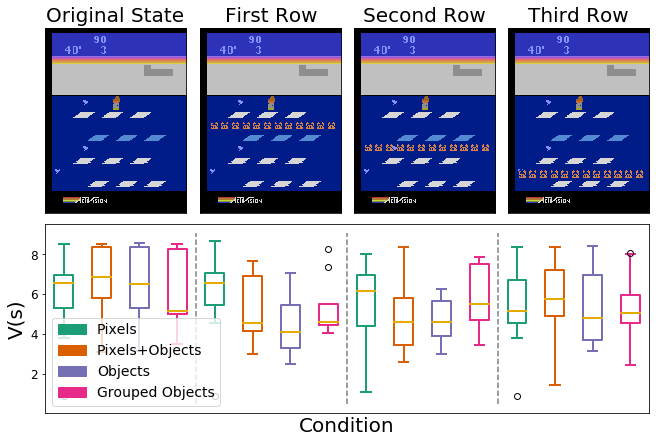

In [21]:
SRC_OBS_INDEX = 1270
CHANNEL_INDEX = 1
NEW_LOCATIONS = None
START_LOC = (107, 12)
NUM_AFTER_STATES = 3

    
fig = plt.figure(constrained_layout=True, figsize=(9, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['First Row', 'Second Row', 'Third Row']

major_fontdict = dict(fontsize=20)
minor_fontdict = dict(fontsize=14)

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[0],):
    for i, row_loc_inc in enumerate((0, 25, 55)):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        
        b_ax, b_value_positions = None, None
        if i == 0:
            b_ax = before_ax 
            b_value_positions = before_positions
        
        do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS, 
                                                    after_ax=after_axes[i], values_ax=values_ax, after_value_positions=after_positions[i],
                                                    before_ax=b_ax, before_value_positions=b_value_positions, additional_boxplot_properties=None,
                                                    before_title='Original State', after_title=after_titles[i],
                                                    major_fontdict=major_fontdict,
                                                    minor_fontdict=minor_fontdict,
                                                    hsv=None, object_index=0, object_pixels_and_mask=None
                                                    )
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

values_ax.tick_params(axis='both', which='major', labelsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='best', **minor_fontdict)


# save('crabs_panel.pdf')

plt.show()

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.681, median = 3.915 | After mean = 3.885, median = 4.320 
For model Pixels+Objects | Before mean = 4.193, median = 4.247 | After mean = 5.355, median = 5.060 
For model Objects | Before mean = 4.896, median = 4.239 | After mean = 5.499, median = 5.246 
For model Grouped Objects | Before mean = 3.870, median = 3.614 | After mean = 3.184, median = 2.865 
For models Pixels and Pixels+Objects, t = -2.060 => P = 0.054 (n = 10)
For models Pixels and Objects, t = -2.243 => P = 0.038* (n = 10)
For models Pixels and Grouped Objects, t = 0.931 => P = 0.365 (n = 10)
For models Pixels+Objects and Objects, t = -0.208 => P = 0.838 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 3.005 => P = 0.008** (n = 10)
For models Objects and Grouped Objects, t = 3.176 => P = 0.006** (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.681, median = 3.915 | After mean = 4.017, median = 4.586 
For model Pixels+Objects | Before mean = 4.193, median = 4.247 | After mean = 5.383, median = 5.361 
For model Objects | Before mean = 4.896, median = 4.239 | After mean = 5.499, median = 5.246 
For model Grouped Objects | Before mean = 3.870, median = 3.614 | After mean = 2.943, median = 2.999 
For models Pixels and Pixels+Objects, t = -1.934 => P = 0.069 (n = 10)
For models Pixels and Objects, t = -2.082 => P = 0.052 (n = 10)
For models Pixels and Grouped Objects, t = 1.399 => P = 0.180 (n = 10)
For models Pixels+Objects and Objects, t = -0.168 => P = 0.869 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 3.262 => P = 0.005** (n = 10)
For models Objects and Grouped Objects, t = 3.391 => P = 0.003** (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.681, median = 3.915 | After mean = 3.754, median = 3.939 
For model Pixels+Objects | Before mean = 4.193, median = 4.247 | After mean = 5.258, median = 4.893 
For model Objects | Before mean = 4.896, median = 4.239 | After mean = 5.499, median = 5.246 
For model Grouped Objects | Before mean = 3.870, median = 3.614 | After mean = 3.436, median = 3.524 
For models Pixels and Pixels+Objects, t = -1.965 => P = 0.065 (n = 10)
For models Pixels and Objects, t = -2.296 => P = 0.034* (n = 10)
For models Pixels and Grouped Objects, t = 0.407 => P = 0.689 (n = 10)
For models Pixels+Objects and Objects, t = -0.343 => P = 0.735 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 2.530 => P = 0.022* (n = 10)
For models Objects and Grouped Objects, t = 2.889 => P = 0.010* (n = 10)


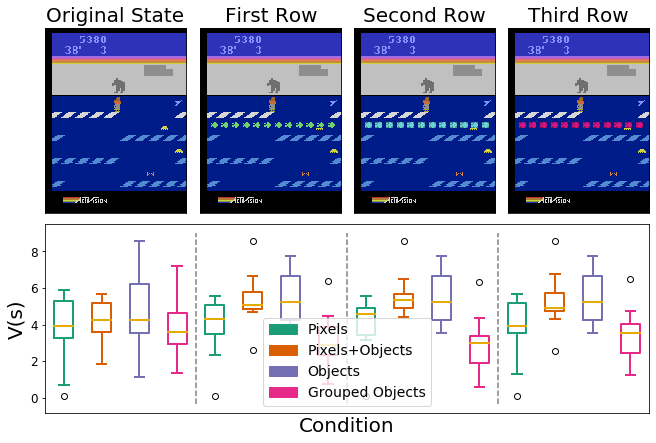

In [22]:
SRC_OBS_INDEX = 310
CHANNEL_INDEX = 6
NUM_AFTER_STATES = 3
START_LOC = (107, 12)
row_loc_inc = 0

colors = ('green', 'blue', 'red')

    
fig = plt.figure(constrained_layout=True, figsize=(9, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['First Row', 'Second Row', 'Third Row']

major_fontdict = dict(fontsize=20)
minor_fontdict = dict(fontsize=14)

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[1],):
    for i, hue in enumerate((None, 0.5, 0.9)):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        
        b_ax, b_value_positions = None, None
        if i == 0:
            b_ax = before_ax 
            b_value_positions = before_positions
        
        do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS, 
                                                    after_ax=after_axes[i], values_ax=values_ax, after_value_positions=after_positions[i],
                                                    before_ax=b_ax, before_value_positions=b_value_positions, additional_boxplot_properties=None,
                                                    before_title='Original State', after_title=after_titles[i],
                                                    major_fontdict=major_fontdict,
                                                    minor_fontdict=minor_fontdict,
                                                    hsv=(hue, hue, None), object_index=0, object_pixels_and_mask=None
                                                    )
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

values_ax.tick_params(axis='both', which='major', labelsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='best', **minor_fontdict)

# TODO add legend

# save('fish_panel.pdf')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4654, device='cuda:0')
tensor(0.5491, device='cuda:0')


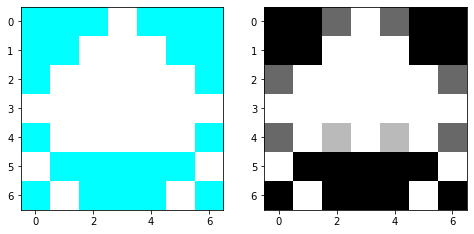

In [23]:
alien_pixels_tensor = torch.tensor([[  0,   0,  52, 243,  52,   0,   0],
       [  0,   0, 243, 243, 243,   0,   0],
       [ 52, 243, 202, 243, 202, 243,  52],
       [243, 243, 148, 243, 148, 243, 243],
       [ 52, 243,  93, 243,  93, 243,  52],
       [243,   0,   0,   0,   0,   0, 243],
       [  0, 243,   0,   0,   0, 243,   0]], dtype=torch.float32, device=baseline_env.device) / 255

print(alien_pixels_tensor.mean())
# print(bad_animal_pixels_tensor.mean(), fish_pixels_tensor.mean(), igloo_pixels_tensor.mean(), player_pixels_tensor.mean())

alien_mask_tensor = change_intensity(alien_pixels_tensor, multiplicative=2)
print(alien_mask_tensor.mean())
# print(bad_animal_mask_tensor.mean(), fish_mask_tensor.mean(), igloo_mask_tensor.mean(), player_mask_tensor.mean())


alien_pixels_tensor_color = alien_pixels_tensor.repeat(3, 1, 1).permute(1, 2, 0)

water_color = torch.tensor([  0.,  28., 136.], device='cuda:0') / 255

black_indices = torch.all(alien_pixels_tensor_color == alien_pixels_tensor_color[0, 0], axis=2)
gray_indices = torch.all(alien_pixels_tensor_color == alien_pixels_tensor_color[0, 2], axis=2)

alien_pixels_tensor_color[black_indices + gray_indices] = water_color

alien_pixels_and_mask = (alien_pixels_tensor_color * 255, alien_mask_tensor)
plot_tensors(*alien_pixels_and_mask, norm=True)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.919, median = 6.670 | After mean = 3.435, median = 3.465 
For model Pixels+Objects | Before mean = 6.169, median = 6.392 | After mean = 8.011, median = 8.353 
For model Objects | Before mean = 6.175, median = 6.040 | After mean = 7.886, median = 8.167 
For model Grouped | Before mean = 6.460, median = 6.308 | After mean = 5.558, median = 5.938 
For models Pixels and Pixels+Objects, t = -6.101 => P = 0.000** (n = 10)
For models Pixels and Objects, t = -5.761 => P = 0.000** (n = 10)
For models Pixels and Grouped, t = -2.718 => P = 0.015* (n = 10)
For models Pixels+Objects and Objects, t = 0.206 => P = 0.839 (n = 10)
For models Pixels+Objects and Grouped, t = 4.128 => P = 0.001** (n = 10)
For models Objects and Grouped, t = 3.720 => P = 0.002** (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.919, median = 6.670 | After mean = 3.948, median = 4.228 
For model Pixels+Objects | Before mean = 6.169, median = 6.392 | After mean = 3.881, median = 4.279 
For model Objects | Before mean = 6.175, median = 6.040 | After mean = 2.496, median = 2.115 
For model Grouped | Before mean = 6.460, median = 6.308 | After mean = 5.010, median = 4.646 
For models Pixels and Pixels+Objects, t = 0.081 => P = 0.936 (n = 10)
For models Pixels and Objects, t = 2.159 => P = 0.045* (n = 10)
For models Pixels and Grouped, t = -1.619 => P = 0.124 (n = 10)
For models Pixels+Objects and Objects, t = 1.905 => P = 0.073 (n = 10)
For models Pixels+Objects and Grouped, t = -1.574 => P = 0.134 (n = 10)
For models Objects and Grouped, t = -5.019 => P = 0.000** (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.919, median = 6.670 | After mean = 3.256, median = 3.074 
For model Pixels+Objects | Before mean = 6.169, median = 6.392 | After mean = 8.411, median = 8.302 
For model Objects | Before mean = 6.175, median = 6.040 | After mean = 8.379, median = 8.639 
For model Grouped | Before mean = 6.460, median = 6.308 | After mean = 5.704, median = 5.707 
For models Pixels and Pixels+Objects, t = -7.902 => P = 0.000** (n = 10)
For models Pixels and Objects, t = -7.766 => P = 0.000** (n = 10)
For models Pixels and Grouped, t = -3.359 => P = 0.004** (n = 10)
For models Pixels+Objects and Objects, t = 0.078 => P = 0.938 (n = 10)
For models Pixels+Objects and Grouped, t = 5.580 => P = 0.000** (n = 10)
For models Objects and Grouped, t = 5.393 => P = 0.000** (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.919, median = 6.670 | After mean = 3.256, median = 3.074 
For model Pixels+Objects | Before mean = 6.169, median = 6.392 | After mean = 4.168, median = 4.866 
For model Objects | Before mean = 6.175, median = 6.040 | After mean = 2.558, median = 2.480 
For model Grouped | Before mean = 6.460, median = 6.308 | After mean = 5.704, median = 5.707 
For models Pixels and Pixels+Objects, t = -1.098 => P = 0.287 (n = 10)
For models Pixels and Objects, t = 1.014 => P = 0.324 (n = 10)
For models Pixels and Grouped, t = -3.359 => P = 0.004** (n = 10)
For models Pixels+Objects and Objects, t = 2.342 => P = 0.031* (n = 10)
For models Pixels+Objects and Grouped, t = -2.110 => P = 0.050* (n = 10)
For models Objects and Grouped, t = -5.858 => P = 0.000** (n = 10)
T-tests for model Pixels
For conditions Before and Fish, t = 2.719 => P = 0.014* (n = 10)
For conditions Before and Crabs, t = 2.283 => P = 0.035* (n = 10)
For conditions Before and Good Aliens, t = 3.008 =

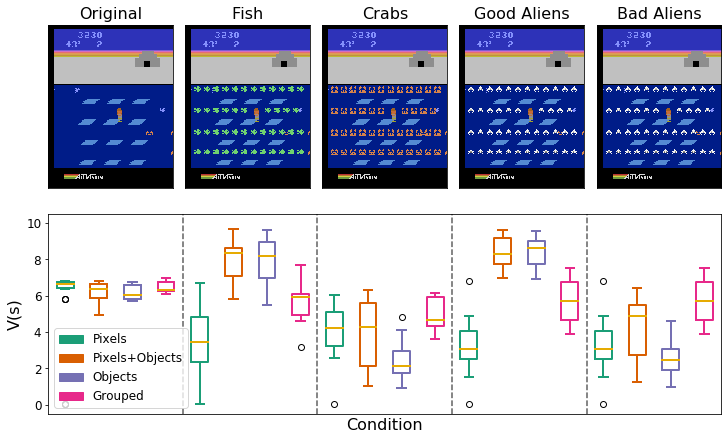

In [120]:
SRC_OBS_INDEX = 310
DST_OBS_INDEX = 875
FISH_CHANNEL_INDEX = 6

LOCATION_COLLECTIONS = (
    [(80, 12 + 12 * i) for i in range(12)],
    [(107, 12 + 12 * i) for i in range(6)],
    [(107, 6 + 12 * i) for i in range(8, 12)],
    [(135, 12 + 12 * i) for i in range(12)],
    [(160, 12 + 12 * i) for i in range(12)],
#     [(85, 12 + 12 * i) for i in range(12)],
)

NEW_LOCATIONS = []
for loc in LOCATION_COLLECTIONS:
    NEW_LOCATIONS.extend(loc)

NUM_AFTER_STATES = 4
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Fish', 'Crabs', 'Good Aliens', 'Bad Aliens']

YLIM = (-0.5, 10.5)

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

# FISH
IDX = 0
        
before_values, first_after_values = do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, FISH_CHANNEL_INDEX, NEW_LOCATIONS, 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None
                                            )


# CRABS
IDX = 1
CRABS_SRC_OBS_INDEX = 1270
CRABS_CHANNEL_INDEX = 1

_, second_after_values = do_multiple_augmentation_comparison_single_plot(CRABS_SRC_OBS_INDEX, DST_OBS_INDEX, CRABS_CHANNEL_INDEX, NEW_LOCATIONS, 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=None, before_value_positions=None, additional_boxplot_properties=None,
                                            before_title='Original State', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None
                                            )


# Aliens as fish
IDX = 2
_, third_after_values = do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, FISH_CHANNEL_INDEX, NEW_LOCATIONS, 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=alien_pixels_and_mask
                                            )

# Aliens as crabs
IDX = 3
_, fourth_after_values = do_multiple_augmentation_comparison_single_plot(CRABS_SRC_OBS_INDEX, DST_OBS_INDEX, CRABS_CHANNEL_INDEX, NEW_LOCATIONS, 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=alien_pixels_and_mask
                                            )



print('=' * 50)
condition_names = ['Before'] + after_titles
for model_name, before, first_after, second_after, third_after, fourth_after in zip(FINAL_NAMES, before_values, first_after_values, second_after_values, third_after_values, fourth_after_values):
    print(f'T-tests for model {model_name}')
    value_sets = [before, first_after, second_after, third_after, fourth_after]
    
    for i in range(len(condition_names)):
        for j in range(i + 1, len(condition_names)):
            first_name = condition_names[i]
            first_after_values = value_sets[i]
            
            second_name = condition_names[j]
            second_after_values = value_sets[j]
            
            t, p = stats.ttest_ind(first_after_values, second_after_values)
            print(f'For conditions {first_name} and {second_name}, t = {t:.3f} => P = {p:.3f}{"*" if p <= 0.05 else ""}{"*" if p <= 0.01 else ""} (n = {len(first_after_values)})')
                  
    print('=' * 50)
    
    
dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *YLIM, colors='gray', linestyles='dashed')

        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *YLIM, colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

values_ax.tick_params(axis='both', which='major', labelsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.set_ylim(*YLIM)
values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

save('alien_panel_smaller_fonts_with_grouped.pdf')

plt.show()

# Final(??) Take on surrounding/stranding an agent

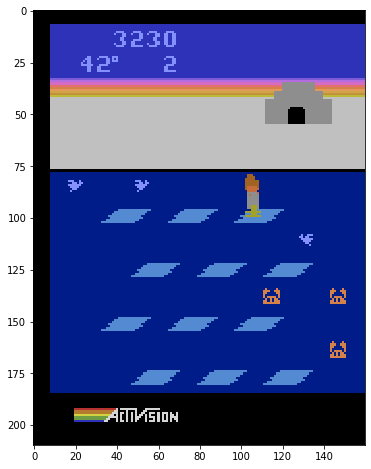

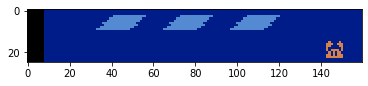

In [108]:
plt.figure(figsize=(6, 8))
plt.imshow(sample_full_color_observations[BASE_STATE_INDEX])
plt.show()

plt.imshow(sample_full_color_observations[BASE_STATE_INDEX, 145:170])
plt.show()

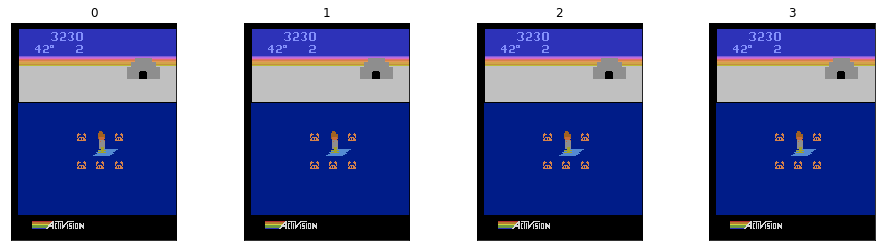

In [113]:
def shift_slice(src_slice, shift):
    return slice(src_slice.start + shift, src_slice.stop + shift, src_slice.step)


BASE_STATE_INDEX = 887
OCEAN_ROW_RANGE = slice(78, 186)
OCEAN_COL_RANGE = slice(7, None)

PLAYER_AND_FLOE_SRC_ROW_RANGE = slice(78, 104)
PLAYER_AND_FLOE_SRC_COL_RANGE = slice(96, 122)

PLAYER_AND_FLOE_DST_ROW_RANGE = slice(104, 130)
PLAYER_AND_FLOE_DST_COL_RANGE = slice(78, 104)

CRAB_SRC_ROW_RANGE = slice(133, 143)
CRAB_SRC_COL_RANGE = slice(142, 152)

CRAB_DST_POSITIONS = (
    (slice(106, 116), slice(63, 73)),
    (slice(106, 116), slice(99, 109)),
    (slice(133, 143), slice(63, 73)),
    (slice(133, 143), slice(81, 91)),
    (slice(133, 143), slice(99, 109)),
)

TOP_FLOES_STATE_INDEX = 888
TOP_FLOES_ROW_RANGE = slice(95, 104)
TOP_FLOES_COL_RANGE = slice(30, 122)


BASE_VERTICAL_SHIFT = 0
BASE_HORIZONTAL_SHIFT = 0
BASE_SHIFT = (BASE_VERTICAL_SHIFT, BASE_HORIZONTAL_SHIFT)
STATE_LENGTH = 4

player_sprite = sample_full_color_observations[BASE_STATE_INDEX, PLAYER_AND_FLOE_SRC_ROW_RANGE, PLAYER_AND_FLOE_SRC_COL_RANGE]
crab_sprite = sample_full_color_observations[BASE_STATE_INDEX, CRAB_SRC_ROW_RANGE, CRAB_SRC_COL_RANGE]
top_floes_sprite = sample_full_color_observations[TOP_FLOES_STATE_INDEX, TOP_FLOES_ROW_RANGE, TOP_FLOES_COL_RANGE]

base_state_frames = []
for i in range(STATE_LENGTH):
    frame_shift = [x * (STATE_LENGTH - 1 - i) for x in BASE_SHIFT]

    base_state = np.copy(sample_full_color_observations[BASE_STATE_INDEX])
    base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = base_state[111, -1]
    
    base_state[shift_slice(PLAYER_AND_FLOE_DST_ROW_RANGE, frame_shift[0]), shift_slice(PLAYER_AND_FLOE_DST_COL_RANGE, frame_shift[1])] = player_sprite
    
    for crab_dst_row_slice, crab_dst_col_slice in CRAB_DST_POSITIONS:
        base_state[shift_slice(crab_dst_row_slice, frame_shift[0]), shift_slice(crab_dst_col_slice, frame_shift[1])] = crab_sprite
    
    base_state_frames.append(base_state)

moving_base_state_observations = np.stack(base_state_frames)

plot_observations_by_indices(moving_base_state_observations, range(len(moving_base_state_observations)))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.485, median = 4.213 | After mean = 3.843, median = 4.170 
For model Pixels+Objects | Before mean = 3.212, median = 3.129 | After mean = 4.058, median = 3.865 
For model Objects | Before mean = 2.178, median = 1.584 | After mean = 2.944, median = 2.589 
For model Grouped | Before mean = 2.624, median = 2.149 | After mean = 3.684, median = 3.707 
For models Pixels and Pixels+Objects, t = -0.289 => P = 0.776 (n = 10)
For models Pixels and Objects, t = 1.042 => P = 0.311 (n = 10)
For models Pixels and Grouped, t = 0.174 => P = 0.864 (n = 10)
For models Pixels+Objects and Objects, t = 1.838 => P = 0.083 (n = 10)
For models Pixels+Objects and Grouped, t = 0.578 => P = 0.571 (n = 10)
For models Objects and Grouped, t = -0.931 => P = 0.365 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.485, median = 4.213 | After mean = 3.462, median = 4.145 
For model Pixels+Objects | Before mean = 3.212, median = 3.129 | After mean = 3.342, median = 3.343 
For model Objects | Before mean = 2.178, median = 1.584 | After mean = 1.629, median = 1.242 
For model Grouped | Before mean = 2.624, median = 2.149 | After mean = 2.307, median = 2.178 
For models Pixels and Pixels+Objects, t = 0.135 => P = 0.894 (n = 10)
For models Pixels and Objects, t = 2.107 => P = 0.049* (n = 10)
For models Pixels and Grouped, t = 1.259 => P = 0.225 (n = 10)
For models Pixels+Objects and Objects, t = 2.755 => P = 0.013* (n = 10)
For models Pixels+Objects and Grouped, t = 1.581 => P = 0.132 (n = 10)
For models Objects and Grouped, t = -1.094 => P = 0.289 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.485, median = 4.213 | After mean = 3.560, median = 3.213 
For model Pixels+Objects | Before mean = 3.212, median = 3.129 | After mean = 2.661, median = 2.459 
For model Objects | Before mean = 2.178, median = 1.584 | After mean = 2.365, median = 2.371 
For model Grouped | Before mean = 2.624, median = 2.149 | After mean = 2.212, median = 1.694 
For models Pixels and Pixels+Objects, t = 0.916 => P = 0.372 (n = 10)
For models Pixels and Objects, t = 1.145 => P = 0.267 (n = 10)
For models Pixels and Grouped, t = 1.235 => P = 0.234 (n = 10)
For models Pixels+Objects and Objects, t = 0.396 => P = 0.697 (n = 10)
For models Pixels+Objects and Grouped, t = 0.580 => P = 0.570 (n = 10)
For models Objects and Grouped, t = 0.178 => P = 0.860 (n = 10)
T-tests for model Pixels
For conditions Before and Escape Route, t = -0.383 => P = 0.706 (n = 10)
For conditions Before and Death #1, t = 0.024 => P = 0.981 (n = 10)
For conditions Before and Death #2, t = -0.070 => 

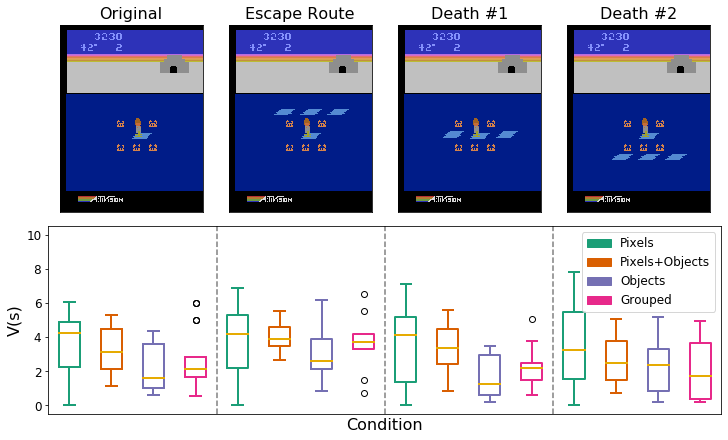

In [118]:
SRC_OBS_INDEX = BASE_STATE_INDEX
DST_OBS_INDEX = 3
VISITED_FLOE_CHANNEL_INDEX = 5

# FLOE_ROW_LOCATION = 95
# START_COL_LOCATIONS = (10, 45, 105)
# FLOE_COL_LOCATION_INCREMENTS = (0, 30)  # (0, 30, 60)
# LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
#                  for start in START_COL_LOCATIONS]

LOCATION_SETS = (
    ((95, 50),  (95, 80),  (95, 110)),  # top row
    ((120, 50),            (120, 110)),  # middle row
    ((145, 50), (145, 80), (145, 110)),  # bottom row
)

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Escape Route', 'Death #1', 'Death #2']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

IDX = 0        
before_values, first_after_values = do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)


IDX = 1
_, second_after_values = do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)


IDX = 2
_, third_after_values = do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)
        
print('=' * 50)
condition_names = ['Before'] + after_titles
for model_name, before, first_after, second_after, third_after in zip(FINAL_NAMES, before_values, first_after_values, second_after_values, third_after_values):
    print(f'T-tests for model {model_name}')
    value_sets = [before, first_after, second_after, third_after]
    
    for i in range(len(condition_names)):
        for j in range(i + 1, len(condition_names)):
            first_name = condition_names[i]
            first_after_values = value_sets[i]
            
            second_name = condition_names[j]
            second_after_values = value_sets[j]
            
            t, p = stats.ttest_ind(first_after_values, second_after_values)
            print(f'For conditions {first_name} and {second_name}, t = {t:.3f} => P = {p:.3f}{"*" if p <= 0.05 else ""}{"*" if p <= 0.01 else ""} (n = {len(first_after_values)})')
                  
    print('=' * 50)
    
    
dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *YLIM, colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.set_ylim(*YLIM)
values_ax.tick_params(axis='both', which='major', labelsize=12)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='upper right', **minor_fontdict)

save(f'crab_stranded_agent_panel_no_shift.pdf')
# plt.title('Shift = 0', fontsize=24)
plt.show()

-----------

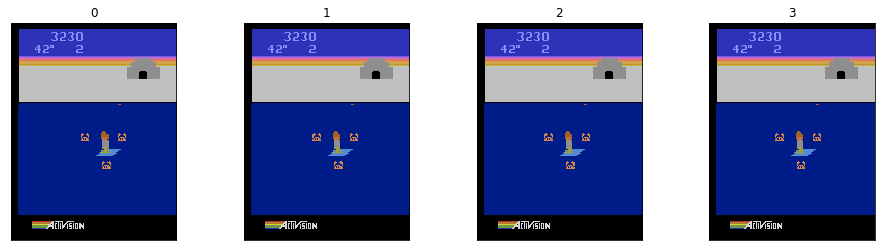

In [88]:
def shift_slice(src_slice, shift):
    return slice(src_slice.start + shift, src_slice.stop + shift, src_slice.step)


BASE_STATE_INDEX = 887
OCEAN_ROW_RANGE = slice(80, 186)
OCEAN_COL_RANGE = slice(7, None)

PLAYER_AND_FLOE_SRC_ROW_RANGE = slice(78, 104)
PLAYER_AND_FLOE_SRC_COL_RANGE = slice(96, 122)

PLAYER_AND_FLOE_DST_ROW_RANGE = slice(104, 130)
PLAYER_AND_FLOE_DST_COL_RANGE = slice(78, 104)

CRAB_SRC_ROW_RANGE = slice(133, 143)
CRAB_SRC_COL_RANGE = slice(142, 152)

CRAB_DST_POSITIONS = (
    (slice(106, 116), slice(63, 73)),
    (slice(106, 116), slice(99, 109)),
    (slice(133, 143), slice(84, 94)),
)

TOP_FLOES_STATE_INDEX = 888
TOP_FLOES_ROW_RANGE = slice(95, 104)
TOP_FLOES_COL_RANGE = slice(30, 122)


BASE_VERTICAL_SHIFT = 0
BASE_HORIZONTAL_SHIFT = 1
BASE_SHIFT = (BASE_VERTICAL_SHIFT, BASE_HORIZONTAL_SHIFT)
STATE_LENGTH = 4

player_sprite = sample_full_color_observations[BASE_STATE_INDEX, PLAYER_AND_FLOE_SRC_ROW_RANGE, PLAYER_AND_FLOE_SRC_COL_RANGE]
crab_sprite = sample_full_color_observations[BASE_STATE_INDEX, CRAB_SRC_ROW_RANGE, CRAB_SRC_COL_RANGE]
top_floes_sprite = sample_full_color_observations[TOP_FLOES_STATE_INDEX, TOP_FLOES_ROW_RANGE, TOP_FLOES_COL_RANGE]

base_state_frames = []
for i in range(STATE_LENGTH):
    frame_shift = [x * (STATE_LENGTH - 1 - i) for x in BASE_SHIFT]

    base_state = np.copy(sample_full_color_observations[BASE_STATE_INDEX])
    base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = base_state[111, -1]
    
    base_state[shift_slice(PLAYER_AND_FLOE_DST_ROW_RANGE, frame_shift[0]), shift_slice(PLAYER_AND_FLOE_DST_COL_RANGE, frame_shift[1])] = player_sprite
    
    for crab_dst_row_slice, crab_dst_col_slice in CRAB_DST_POSITIONS:
        base_state[shift_slice(crab_dst_row_slice, frame_shift[0]), shift_slice(crab_dst_col_slice, frame_shift[1])] = crab_sprite
    
    base_state_frames.append(base_state)

moving_base_state_observations = np.stack(base_state_frames)

plot_observations_by_indices(moving_base_state_observations, range(len(moving_base_state_observations)))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 4.416, median = 4.766 | After mean = 3.823, median = 4.360 
For model Pixels+Objects | Before mean = 2.693, median = 2.453 | After mean = 2.761, median = 2.396 
For model Objects | Before mean = 1.863, median = 1.022 | After mean = 1.705, median = 1.308 
For model Grouped Objects | Before mean = 3.823, median = 3.659 | After mean = 3.467, median = 3.266 
For models Pixels and Pixels+Objects, t = 1.638 => P = 0.119 (n = 10)
For models Pixels and Objects, t = 3.070 => P = 0.007** (n = 10)
For models Pixels and Grouped Objects, t = 0.381 => P = 0.708 (n = 10)
For models Pixels+Objects and Objects, t = 2.136 => P = 0.047* (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.902 => P = 0.380 (n = 10)
For models Objects and Grouped Objects, t = -2.145 => P = 0.047* (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 4.416, median = 4.766 | After mean = 4.485, median = 4.692 
For model Pixels+Objects | Before mean = 2.693, median = 2.453 | After mean = 3.815, median = 3.848 
For model Objects | Before mean = 1.863, median = 1.022 | After mean = 2.369, median = 2.368 
For model Grouped Objects | Before mean = 3.823, median = 3.659 | After mean = 4.030, median = 4.038 
For models Pixels and Pixels+Objects, t = 0.986 => P = 0.337 (n = 10)
For models Pixels and Objects, t = 2.813 => P = 0.012* (n = 10)
For models Pixels and Grouped Objects, t = 0.483 => P = 0.635 (n = 10)
For models Pixels+Objects and Objects, t = 2.457 => P = 0.024* (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.269 => P = 0.791 (n = 10)
For models Objects and Grouped Objects, t = -1.910 => P = 0.073 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 4.416, median = 4.766 | After mean = 3.427, median = 3.771 
For model Pixels+Objects | Before mean = 2.693, median = 2.453 | After mean = 2.410, median = 2.510 
For model Objects | Before mean = 1.863, median = 1.022 | After mean = 1.912, median = 2.250 
For model Grouped Objects | Before mean = 3.823, median = 3.659 | After mean = 3.697, median = 3.683 
For models Pixels and Pixels+Objects, t = 1.806 => P = 0.088 (n = 10)
For models Pixels and Objects, t = 2.385 => P = 0.028* (n = 10)
For models Pixels and Grouped Objects, t = -0.366 => P = 0.719 (n = 10)
For models Pixels+Objects and Objects, t = 1.107 => P = 0.283 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -2.277 => P = 0.036* (n = 10)
For models Objects and Grouped Objects, t = -2.768 => P = 0.013* (n = 10)
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/crab_stranded_agent_panel_shift_-1.pdf}
\caption{ {\bf FIGURE TITLE.} FIGU

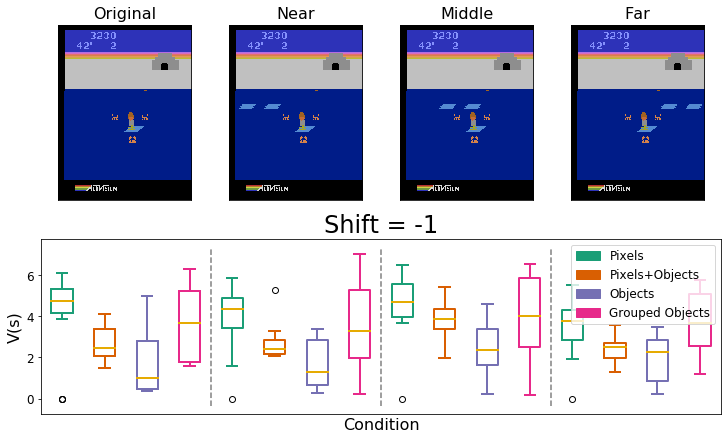

In [89]:
SRC_OBS_INDEX = BASE_STATE_INDEX
DST_OBS_INDEX = 3
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 95
START_COL_LOCATIONS = (10, 45, 105)
FLOE_COL_LOCATION_INCREMENTS = (0, 30)  # (0, 30, 60)

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

augmentation_horizontal_shift = -BASE_HORIZONTAL_SHIFT  # positive shift = to the left in earlier frames

# Near
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))

# Far only
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))


# Both
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *YLIM, colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)
values_ax.set_ylim(*YLIM)
values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='upper right', **minor_fontdict)

save(f'crab_stranded_agent_panel_shift_{augmentation_horizontal_shift}.pdf')
plt.title(f'Shift = {augmentation_horizontal_shift}', fontsize=24)
plt.show()

----------------

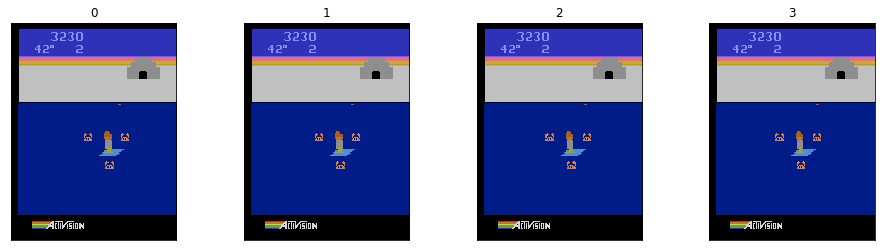

In [90]:
def shift_slice(src_slice, shift):
    return slice(src_slice.start + shift, src_slice.stop + shift, src_slice.step)


BASE_STATE_INDEX = 887
OCEAN_ROW_RANGE = slice(80, 186)
OCEAN_COL_RANGE = slice(7, None)

PLAYER_AND_FLOE_SRC_ROW_RANGE = slice(78, 104)
PLAYER_AND_FLOE_SRC_COL_RANGE = slice(96, 122)

PLAYER_AND_FLOE_DST_ROW_RANGE = slice(104, 130)
PLAYER_AND_FLOE_DST_COL_RANGE = slice(78, 104)

CRAB_SRC_ROW_RANGE = slice(133, 143)
CRAB_SRC_COL_RANGE = slice(142, 152)

CRAB_DST_POSITIONS = (
    (slice(106, 116), slice(63, 73)),
    (slice(106, 116), slice(99, 109)),
    (slice(133, 143), slice(84, 94)),
)

TOP_FLOES_STATE_INDEX = 888
TOP_FLOES_ROW_RANGE = slice(95, 104)
TOP_FLOES_COL_RANGE = slice(30, 122)


BASE_VERTICAL_SHIFT = 0
BASE_HORIZONTAL_SHIFT = 2
BASE_SHIFT = (BASE_VERTICAL_SHIFT, BASE_HORIZONTAL_SHIFT)
STATE_LENGTH = 4

player_sprite = sample_full_color_observations[BASE_STATE_INDEX, PLAYER_AND_FLOE_SRC_ROW_RANGE, PLAYER_AND_FLOE_SRC_COL_RANGE]
crab_sprite = sample_full_color_observations[BASE_STATE_INDEX, CRAB_SRC_ROW_RANGE, CRAB_SRC_COL_RANGE]
top_floes_sprite = sample_full_color_observations[TOP_FLOES_STATE_INDEX, TOP_FLOES_ROW_RANGE, TOP_FLOES_COL_RANGE]

base_state_frames = []
for i in range(STATE_LENGTH):
    frame_shift = [x * (STATE_LENGTH - 1 - i) for x in BASE_SHIFT]

    base_state = np.copy(sample_full_color_observations[BASE_STATE_INDEX])
    base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = base_state[111, -1]
    
    base_state[shift_slice(PLAYER_AND_FLOE_DST_ROW_RANGE, frame_shift[0]), shift_slice(PLAYER_AND_FLOE_DST_COL_RANGE, frame_shift[1])] = player_sprite
    
    for crab_dst_row_slice, crab_dst_col_slice in CRAB_DST_POSITIONS:
        base_state[shift_slice(crab_dst_row_slice, frame_shift[0]), shift_slice(crab_dst_col_slice, frame_shift[1])] = crab_sprite
    
    base_state_frames.append(base_state)

moving_base_state_observations = np.stack(base_state_frames)

plot_observations_by_indices(moving_base_state_observations, range(len(moving_base_state_observations)))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.828, median = 4.233 | After mean = 2.896, median = 3.570 
For model Pixels+Objects | Before mean = 2.544, median = 1.959 | After mean = 2.528, median = 2.212 
For model Objects | Before mean = 1.923, median = 0.838 | After mean = 1.756, median = 1.111 
For model Grouped Objects | Before mean = 3.870, median = 4.014 | After mean = 3.085, median = 2.808 
For models Pixels and Pixels+Objects, t = 0.491 => P = 0.630 (n = 10)
For models Pixels and Objects, t = 1.463 => P = 0.161 (n = 10)
For models Pixels and Grouped Objects, t = -0.202 => P = 0.843 (n = 10)
For models Pixels+Objects and Objects, t = 1.359 => P = 0.191 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.739 => P = 0.470 (n = 10)
For models Objects and Grouped Objects, t = -1.689 => P = 0.109 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.828, median = 4.233 | After mean = 3.505, median = 3.876 
For model Pixels+Objects | Before mean = 2.544, median = 1.959 | After mean = 3.579, median = 3.413 
For model Objects | Before mean = 1.923, median = 0.838 | After mean = 2.144, median = 1.696 
For model Grouped Objects | Before mean = 3.870, median = 4.014 | After mean = 4.268, median = 5.292 
For models Pixels and Pixels+Objects, t = -0.107 => P = 0.916 (n = 10)
For models Pixels and Objects, t = 1.734 => P = 0.100 (n = 10)
For models Pixels and Grouped Objects, t = -0.836 => P = 0.415 (n = 10)
For models Pixels+Objects and Objects, t = 2.243 => P = 0.038* (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.888 => P = 0.387 (n = 10)
For models Objects and Grouped Objects, t = -2.439 => P = 0.026* (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.828, median = 4.233 | After mean = 2.550, median = 1.983 
For model Pixels+Objects | Before mean = 2.544, median = 1.959 | After mean = 2.206, median = 2.223 
For model Objects | Before mean = 1.923, median = 0.838 | After mean = 1.722, median = 1.751 
For model Grouped Objects | Before mean = 3.870, median = 4.014 | After mean = 3.727, median = 3.888 
For models Pixels and Pixels+Objects, t = 0.562 => P = 0.581 (n = 10)
For models Pixels and Objects, t = 1.235 => P = 0.233 (n = 10)
For models Pixels and Grouped Objects, t = -1.477 => P = 0.158 (n = 10)
For models Pixels+Objects and Objects, t = 1.005 => P = 0.328 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -2.427 => P = 0.027* (n = 10)
For models Objects and Grouped Objects, t = -2.904 => P = 0.010** (n = 10)
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/crab_stranded_agent_panel_shift_-2.pdf}
\caption{ {\bf FIGURE TITLE.} FIGU

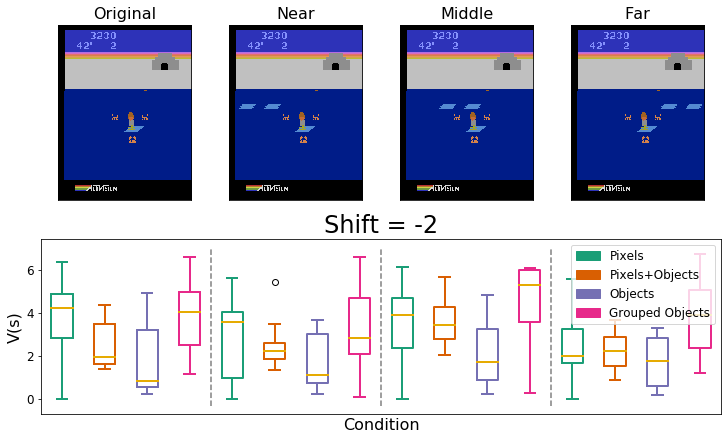

In [91]:
SRC_OBS_INDEX = BASE_STATE_INDEX
DST_OBS_INDEX = 3
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 95
START_COL_LOCATIONS = (10, 45, 105)
FLOE_COL_LOCATION_INCREMENTS = (0, 30)  # (0, 30, 60)

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

augmentation_horizontal_shift = -BASE_HORIZONTAL_SHIFT  # positive shift = to the left in earlier frames

# Near
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))

# Far only
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))


# Both
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *YLIM, colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)
values_ax.set_ylim(*YLIM)
values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='upper right', **minor_fontdict)

save(f'crab_stranded_agent_panel_shift_{augmentation_horizontal_shift}.pdf')
plt.title(f'Shift = {augmentation_horizontal_shift}', fontsize=24)
plt.show()

----------------------


----------------------

## Trying again with an igloo

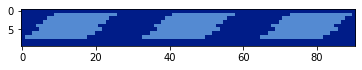

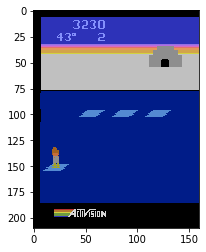

In [114]:
MOVING_BASE_STATE_INDEX = 872
OCEAN_ROW_RANGE = slice(108, 186)
OCEAN_COL_RANGE = slice(7, None)
SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE = slice(132, 155)
SECOND_PLAYER_AND_FLOE_SRC_COL_RANGE = slice(76, 101)
SECOND_PLAYER_AND_FLOE_DST_COL_RANGE = slice(10, 35)

second_player_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE, 
                                                      SECOND_PLAYER_AND_FLOE_SRC_COL_RANGE]
moving_base_state = np.copy(sample_full_color_observations[MOVING_BASE_STATE_INDEX])
moving_base_state[80:95, OCEAN_COL_RANGE] = second_base_state[111, -1]
moving_base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = second_base_state[111, -1]
moving_base_state[SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE, SECOND_PLAYER_AND_FLOE_DST_COL_RANGE] = second_player_sprite

moving_base_state_observations = np.tile(moving_base_state, (4, 1, 1, 1))

plt.imshow(moving_base_state_observations[0])

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.092, median = 3.801 | After mean = 3.135, median = 3.267 
For model Pixels+Objects | Before mean = 3.414, median = 3.704 | After mean = 2.616, median = 2.627 
For model Objects | Before mean = 2.558, median = 2.282 | After mean = 2.210, median = 1.499 
For model Grouped Objects | Before mean = 3.662, median = 3.828 | After mean = 2.916, median = 2.803 
For models Pixels and Pixels+Objects, t = 0.576 => P = 0.572 (n = 10)
For models Pixels and Objects, t = 1.112 => P = 0.281 (n = 10)
For models Pixels and Grouped Objects, t = 0.264 => P = 0.795 (n = 10)
For models Pixels+Objects and Objects, t = 0.539 => P = 0.597 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.406 => P = 0.690 (n = 10)
For models Objects and Grouped Objects, t = -1.098 => P = 0.287 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.092, median = 3.801 | After mean = 3.330, median = 3.098 
For model Pixels+Objects | Before mean = 3.414, median = 3.704 | After mean = 2.954, median = 2.942 
For model Objects | Before mean = 2.558, median = 2.282 | After mean = 2.411, median = 2.363 
For model Grouped Objects | Before mean = 3.662, median = 3.828 | After mean = 2.959, median = 2.613 
For models Pixels and Pixels+Objects, t = 0.449 => P = 0.659 (n = 10)
For models Pixels and Objects, t = 1.213 => P = 0.241 (n = 10)
For models Pixels and Grouped Objects, t = 0.420 => P = 0.680 (n = 10)
For models Pixels+Objects and Objects, t = 0.837 => P = 0.414 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.006 => P = 0.995 (n = 10)
For models Objects and Grouped Objects, t = -0.800 => P = 0.435 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.092, median = 3.801 | After mean = 3.367, median = 3.566 
For model Pixels+Objects | Before mean = 3.414, median = 3.704 | After mean = 2.643, median = 2.448 
For model Objects | Before mean = 2.558, median = 2.282 | After mean = 3.351, median = 3.039 
For model Grouped Objects | Before mean = 3.662, median = 3.828 | After mean = 3.423, median = 3.265 
For models Pixels and Pixels+Objects, t = 0.930 => P = 0.365 (n = 10)
For models Pixels and Objects, t = 0.017 => P = 0.987 (n = 10)
For models Pixels and Grouped Objects, t = -0.062 => P = 0.951 (n = 10)
For models Pixels+Objects and Objects, t = -0.892 => P = 0.384 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -1.051 => P = 0.308 (n = 10)
For models Objects and Grouped Objects, t = -0.078 => P = 0.939 (n = 10)
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/stranded_agent_panel_no_shift.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESC

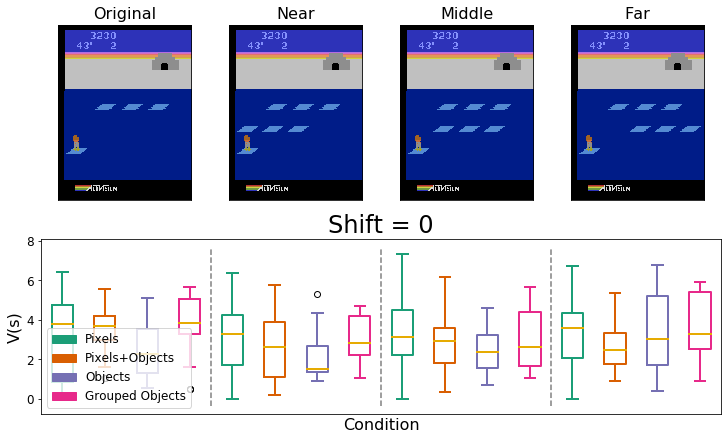

In [137]:
SRC_OBS_INDEX = MOVING_BASE_STATE_INDEX
DST_OBS_INDEX = 3
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 122
START_COL_LOCATIONS = (10, 40, 70)
FLOE_COL_LOCATION_INCREMENTS = (0, 30, 60)

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

# Near
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)

# Far only
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)


# Both
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

save(f'stranded_agent_panel_no_shift.pdf')
plt.title('Shift = 0', fontsize=24)
plt.show()

# Moving the base state and augmentations 

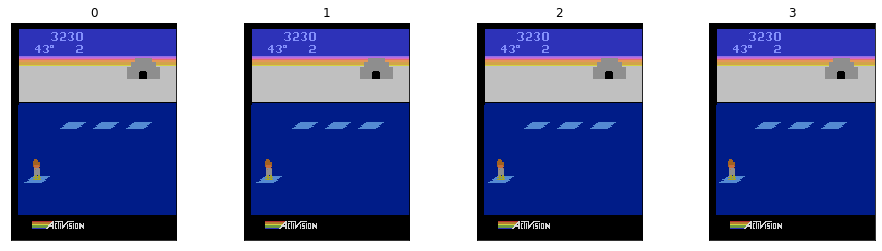

In [139]:
def shift_slice(src_slice, shift):
    return slice(src_slice.start + shift, src_slice.stop + shift, src_slice.step)


MOVING_BASE_STATE_INDEX = 872
OCEAN_ROW_RANGE = slice(80, 186)
OCEAN_COL_RANGE = slice(7, None)
SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE = slice(132, 155)
SECOND_PLAYER_AND_FLOE_SRC_COL_RANGE = slice(76, 101)
SECOND_PLAYER_AND_FLOE_DST_COL_RANGE = slice(10, 35)
TOP_FLOES_ROW_RANGE = slice(95, 105)
TOP_FLOES_COL_RANGE = slice(43, 134)

BASE_VERTICAL_SHIFT = 0
BASE_HORIZONTAL_SHIFT = 1
BASE_SHIFT = (BASE_VERTICAL_SHIFT, BASE_HORIZONTAL_SHIFT)
STATE_LENGTH = 4

second_player_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE, 
                                                      SECOND_PLAYER_AND_FLOE_SRC_COL_RANGE]
top_floes_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, TOP_FLOES_ROW_RANGE, TOP_FLOES_COL_RANGE]

base_state_frames = []
for i in range(STATE_LENGTH):
    frame_shift = [x * (STATE_LENGTH - 1 - i) for x in BASE_SHIFT]

    moving_base_state = np.copy(sample_full_color_observations[MOVING_BASE_STATE_INDEX])
    moving_base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = second_base_state[111, -1]
    
    moving_base_state[shift_slice(SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE, frame_shift[0]), 
                      shift_slice(SECOND_PLAYER_AND_FLOE_DST_COL_RANGE, frame_shift[1])] = second_player_sprite
    
    moving_base_state[shift_slice(TOP_FLOES_ROW_RANGE, frame_shift[0]), 
                      shift_slice(TOP_FLOES_COL_RANGE, frame_shift[1])] = top_floes_sprite
    
    base_state_frames.append(moving_base_state)

moving_base_state_observations = np.stack(base_state_frames)

plot_observations_by_indices(moving_base_state_observations, range(len(moving_base_state_observations)))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.845, median = 4.637 | After mean = 3.608, median = 4.414 
For model Pixels+Objects | Before mean = 3.867, median = 3.501 | After mean = 2.703, median = 2.880 
For model Objects | Before mean = 2.674, median = 2.327 | After mean = 2.170, median = 1.857 
For model Grouped Objects | Before mean = 4.116, median = 4.073 | After mean = 2.694, median = 2.158 
For models Pixels and Pixels+Objects, t = 1.031 => P = 0.316 (n = 10)
For models Pixels and Objects, t = 1.885 => P = 0.076 (n = 10)
For models Pixels and Grouped Objects, t = 1.068 => P = 0.300 (n = 10)
For models Pixels+Objects and Objects, t = 0.803 => P = 0.432 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 0.012 => P = 0.991 (n = 10)
For models Objects and Grouped Objects, t = -0.870 => P = 0.396 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.845, median = 4.637 | After mean = 3.862, median = 3.695 
For model Pixels+Objects | Before mean = 3.867, median = 3.501 | After mean = 2.871, median = 2.688 
For model Objects | Before mean = 2.674, median = 2.327 | After mean = 2.544, median = 2.421 
For model Grouped Objects | Before mean = 4.116, median = 4.073 | After mean = 2.812, median = 2.256 
For models Pixels and Pixels+Objects, t = 1.076 => P = 0.296 (n = 10)
For models Pixels and Objects, t = 1.591 => P = 0.129 (n = 10)
For models Pixels and Grouped Objects, t = 1.100 => P = 0.287 (n = 10)
For models Pixels+Objects and Objects, t = 0.501 => P = 0.623 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 0.074 => P = 0.942 (n = 10)
For models Objects and Grouped Objects, t = -0.405 => P = 0.690 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.845, median = 4.637 | After mean = 3.799, median = 3.457 
For model Pixels+Objects | Before mean = 3.867, median = 3.501 | After mean = 2.822, median = 2.652 
For model Objects | Before mean = 2.674, median = 2.327 | After mean = 3.315, median = 2.753 
For model Grouped Objects | Before mean = 4.116, median = 4.073 | After mean = 3.413, median = 3.095 
For models Pixels and Pixels+Objects, t = 1.074 => P = 0.297 (n = 10)
For models Pixels and Objects, t = 0.494 => P = 0.627 (n = 10)
For models Pixels and Grouped Objects, t = 0.402 => P = 0.693 (n = 10)
For models Pixels+Objects and Objects, t = -0.585 => P = 0.566 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.734 => P = 0.473 (n = 10)
For models Objects and Grouped Objects, t = -0.109 => P = 0.914 (n = 10)
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/stranded_agent_panel_shift_-1.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCR

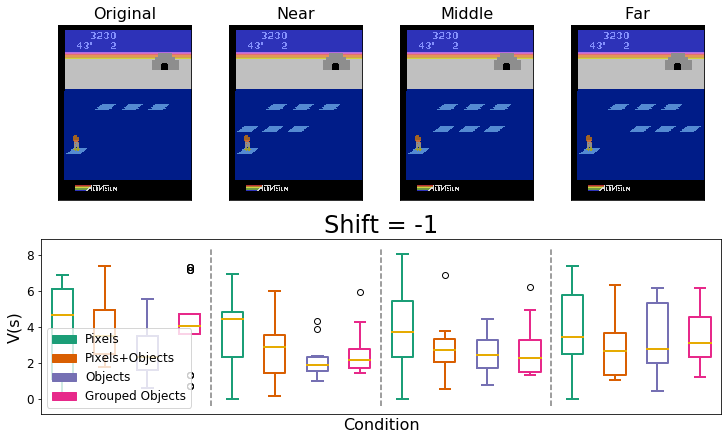

In [140]:
SRC_OBS_INDEX = MOVING_BASE_STATE_INDEX
DST_OBS_INDEX = 3
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 122
START_COL_LOCATIONS = (10, 40, 70)
FLOE_COL_LOCATION_INCREMENTS = (0, 30, 60)

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

augmentation_horizontal_shift = -BASE_HORIZONTAL_SHIFT  # positive shift = to the left in earlier frames

IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))

IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))


# Bth
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

save(f'stranded_agent_panel_shift_{augmentation_horizontal_shift}.pdf')
plt.title(f'Shift = {augmentation_horizontal_shift}', fontsize=24)
plt.show()

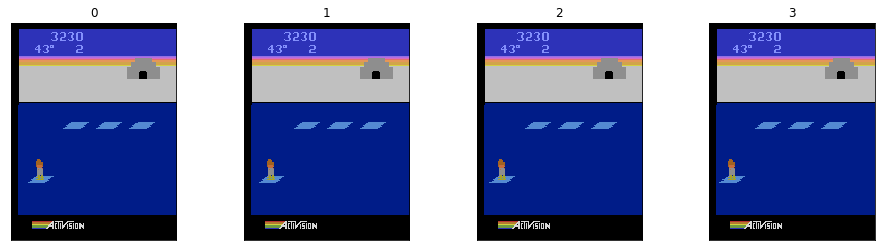

In [141]:
MOVING_BASE_STATE_INDEX = 872
OCEAN_ROW_RANGE = slice(80, 186)
OCEAN_COL_RANGE = slice(7, None)
SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE = slice(132, 155)
SECOND_PLAYER_AND_FLOE_SRC_COL_RANGE = slice(76, 101)
SECOND_PLAYER_AND_FLOE_DST_COL_RANGE = slice(10, 35)
TOP_FLOES_ROW_RANGE = slice(95, 105)
TOP_FLOES_COL_RANGE = slice(43, 134)

BASE_VERTICAL_SHIFT = 0
BASE_HORIZONTAL_SHIFT = 2
BASE_SHIFT = (BASE_VERTICAL_SHIFT, BASE_HORIZONTAL_SHIFT)
STATE_LENGTH = 4

second_player_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE, 
                                                      SECOND_PLAYER_AND_FLOE_SRC_COL_RANGE]
top_floes_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, TOP_FLOES_ROW_RANGE, TOP_FLOES_COL_RANGE]

base_state_frames = []
for i in range(STATE_LENGTH):
    frame_shift = [x * (STATE_LENGTH - 1 - i) for x in BASE_SHIFT]

    moving_base_state = np.copy(sample_full_color_observations[MOVING_BASE_STATE_INDEX])
    moving_base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = second_base_state[111, -1]
    
    moving_base_state[shift_slice(SECOND_PLAYER_AND_FLOE_SRC_ROW_RANGE, frame_shift[0]), 
                      shift_slice(SECOND_PLAYER_AND_FLOE_DST_COL_RANGE, frame_shift[1])] = second_player_sprite
    
    moving_base_state[shift_slice(TOP_FLOES_ROW_RANGE, frame_shift[0]), 
                      shift_slice(TOP_FLOES_COL_RANGE, frame_shift[1])] = top_floes_sprite
    
    base_state_frames.append(moving_base_state)

moving_base_state_observations = np.stack(base_state_frames)

plot_observations_by_indices(moving_base_state_observations, range(len(moving_base_state_observations)))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.092, median = 3.801 | After mean = 3.105, median = 3.734 
For model Pixels+Objects | Before mean = 3.414, median = 3.704 | After mean = 2.387, median = 2.179 
For model Objects | Before mean = 2.558, median = 2.282 | After mean = 2.045, median = 1.501 
For model Grouped Objects | Before mean = 3.662, median = 3.828 | After mean = 2.442, median = 2.078 
For models Pixels and Pixels+Objects, t = 0.979 => P = 0.340 (n = 10)
For models Pixels and Objects, t = 1.577 => P = 0.132 (n = 10)
For models Pixels and Grouped Objects, t = 0.939 => P = 0.361 (n = 10)
For models Pixels+Objects and Objects, t = 0.561 => P = 0.582 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.086 => P = 0.932 (n = 10)
For models Objects and Grouped Objects, t = -0.709 => P = 0.488 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.092, median = 3.801 | After mean = 3.128, median = 3.344 
For model Pixels+Objects | Before mean = 3.414, median = 3.704 | After mean = 2.724, median = 2.696 
For model Objects | Before mean = 2.558, median = 2.282 | After mean = 2.419, median = 2.095 
For model Grouped Objects | Before mean = 3.662, median = 3.828 | After mean = 2.501, median = 1.941 
For models Pixels and Pixels+Objects, t = 0.595 => P = 0.559 (n = 10)
For models Pixels and Objects, t = 1.131 => P = 0.273 (n = 10)
For models Pixels and Grouped Objects, t = 0.890 => P = 0.386 (n = 10)
For models Pixels+Objects and Objects, t = 0.510 => P = 0.616 (n = 10)
For models Pixels+Objects and Grouped Objects, t = 0.330 => P = 0.746 (n = 10)
For models Objects and Grouped Objects, t = -0.133 => P = 0.896 (n = 10)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.092, median = 3.801 | After mean = 3.304, median = 3.356 
For model Pixels+Objects | Before mean = 3.414, median = 3.704 | After mean = 2.453, median = 2.340 
For model Objects | Before mean = 2.558, median = 2.282 | After mean = 3.056, median = 2.582 
For model Grouped Objects | Before mean = 3.662, median = 3.828 | After mean = 2.750, median = 2.394 
For models Pixels and Pixels+Objects, t = 1.134 => P = 0.272 (n = 10)
For models Pixels and Objects, t = 0.291 => P = 0.775 (n = 10)
For models Pixels and Grouped Objects, t = 0.709 => P = 0.488 (n = 10)
For models Pixels+Objects and Objects, t = -0.765 => P = 0.454 (n = 10)
For models Pixels+Objects and Grouped Objects, t = -0.426 => P = 0.676 (n = 10)
For models Objects and Grouped Objects, t = 0.372 => P = 0.714 (n = 10)
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/stranded_agent_panel_shift_-2.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRI

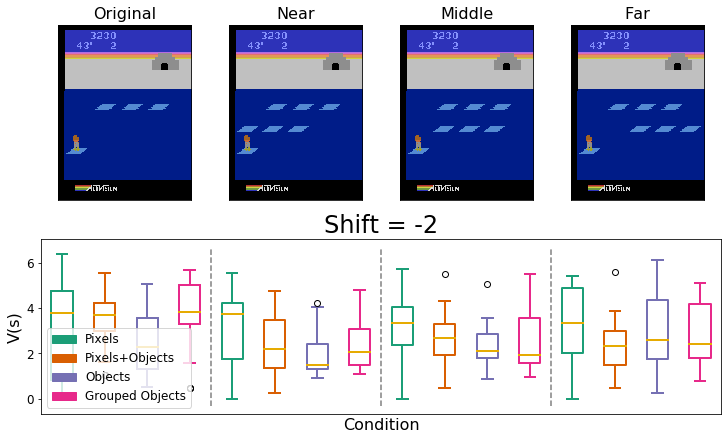

In [142]:
SRC_OBS_INDEX = MOVING_BASE_STATE_INDEX
DST_OBS_INDEX = 3
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 122
START_COL_LOCATIONS = (10, 40, 70)
FLOE_COL_LOCATION_INCREMENTS = (0, 30, 60)

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

augmentation_horizontal_shift = -BASE_HORIZONTAL_SHIFT  # positive shift = to the left in earlier frames

IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))

IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))


# Bth
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True, augmentation_previous_frame_shift=(0, augmentation_horizontal_shift))
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

save(f'stranded_agent_panel_shift_{augmentation_horizontal_shift}.pdf')
plt.title(f'Shift = {augmentation_horizontal_shift}', fontsize=24)
plt.show()

## Trying to create a new stranded agent state
* Both with and without a full igloo?

In [83]:
BASE_STATE_INDEX = 50
OCEAN_ROW_RANGE = slice(77, 186)
OCEAN_COL_RANGE = slice(7, None)
PLAYER_AND_FLOE_ROW_RANGE = slice(129, 156)
PLAYER_AND_FLOE_COL_RANGE = slice(54, 78)

player_sprite = sample_full_color_observations[BASE_STATE_INDEX, PLAYER_AND_FLOE_ROW_RANGE, PLAYER_AND_FLOE_COL_RANGE]
base_state = np.copy(sample_full_color_observations[BASE_STATE_INDEX])
base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = base_state[111, -1]
base_state[PLAYER_AND_FLOE_ROW_RANGE, PLAYER_AND_FLOE_COL_RANGE] = player_sprite

base_state_observations = np.tile(base_state, (10, 1, 1, 1))

# plt.imshow(base_state)

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.706, median = 6.421 | After mean = 4.290, median = 3.159 
For model Pixels+Objects | Before mean = 6.959, median = 6.832 | After mean = 6.521, median = 6.213 
For model Objects | Before mean = 4.500, median = 4.390 | After mean = 5.389, median = 5.404 
For model Grouped Objects | Before mean = 6.425, median = 6.601 | After mean = 4.453, median = 4.571 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.706, median = 6.421 | After mean = 4.357, median = 4.281 
For model Pixels+Objects | Before mean = 6.959, median = 6.832 | After mean = 6.433, median = 6.265 
For model Objects | Before mean = 4.500, median = 4.390 | After mean = 4.463, median = 4.213 
For model Grouped Objects | Before mean = 6.425, median = 6.601 | After mean = 5.708, median = 6.544 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 5.706, median = 6.421 | After mean = 4.010, median = 2.873 
For model Pixels+Objects | Before mean = 6.959, median = 6.832 | After mean = 6.760, median = 6.624 
For model Objects | Before mean = 4.500, median = 4.390 | After mean = 5.378, median = 5.615 
For model Grouped Objects | Before mean = 6.425, median = 6.601 | After mean = 4.794, median = 5.274 


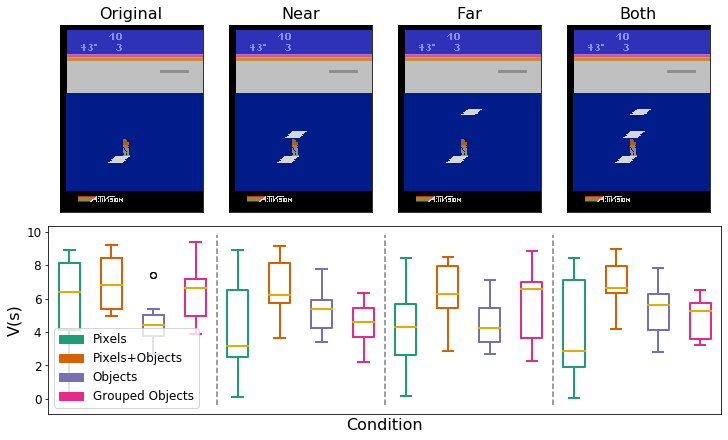

In [84]:
SRC_OBS_INDEX = 5
DST_OBS_INDEX = 5
UNVISITED_FLOE_CHANNEL_INDEX = 4

LOCATIONS = (
    (120, 63),
    (95, 70),
)


NUM_AFTER_STATES = 3
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Far', 'Both']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

# Near only
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, UNVISITED_FLOE_CHANNEL_INDEX, LOCATIONS[0:1], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=base_state_observations,
                                            augment_all_frames=True)

# Far only
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, UNVISITED_FLOE_CHANNEL_INDEX, LOCATIONS[1:2], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=base_state_observations,
                                            augment_all_frames=True)


# Both
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, UNVISITED_FLOE_CHANNEL_INDEX, LOCATIONS, 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=base_state_observations,
                                            augment_all_frames=True)
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

values_ax.tick_params(axis='both', which='major', labelsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

# save('alien_panel_smaller_fonts.pdf')

plt.show()

## What if we move the igloo around, in a state where the agent is about to score?

In [87]:
IGLOO_BASE_STATE_INDEX = 880
IGLOO_ROW_RANGE = slice(35, 55)
IGLOO_COL_RANGE = slice(112, 144)
LAND_COL_RANGE = slice(7, None)

igloo_sprite = sample_full_color_observations[IGLOO_BASE_STATE_INDEX, IGLOO_ROW_RANGE, IGLOO_COL_RANGE]
igloo_base_state = np.copy(sample_full_color_observations[SECOND_BASE_STATE_INDEX])
igloo_base_state[IGLOO_ROW_RANGE, IGLOO_COL_RANGE] = igloo_base_state[IGLOO_ROW_RANGE, 8:9, :]

igloo_base_state_observations = np.tile(igloo_base_state, (10, 1, 1, 1))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 8.977, median = 9.667 | After mean = 7.355, median = 8.148 
For model Pixels+Objects | Before mean = 9.037, median = 9.468 | After mean = 8.124, median = 8.370 
For model Objects | Before mean = 8.277, median = 8.300 | After mean = 7.622, median = 7.647 
For model Grouped Objects | Before mean = 8.538, median = 8.707 | After mean = 7.880, median = 7.440 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 8.977, median = 9.667 | After mean = 8.402, median = 8.870 
For model Pixels+Objects | Before mean = 9.037, median = 9.468 | After mean = 8.080, median = 8.413 
For model Objects | Before mean = 8.277, median = 8.300 | After mean = 6.946, median = 6.939 
For model Grouped Objects | Before mean = 8.538, median = 8.707 | After mean = 8.192, median = 8.309 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 8.977, median = 9.667 | After mean = 6.257, median = 6.785 
For model Pixels+Objects | Before mean = 9.037, median = 9.468 | After mean = 6.258, median = 6.077 
For model Objects | Before mean = 8.277, median = 8.300 | After mean = 6.096, median = 5.998 
For model Grouped Objects | Before mean = 8.538, median = 8.707 | After mean = 6.237, median = 5.845 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 8.977, median = 9.667 | After mean = 5.111, median = 5.376 
For model Pixels+Objects | Before mean = 9.037, median = 9.468 | After mean = 6.145, median = 6.148 
For model Objects | Before mean = 8.277, median = 8.300 | After mean = 5.228, median = 5.205 
For model Grouped Objects | Before mean = 8.538, median = 8.707 | After mean = 5.479, median = 5.339 


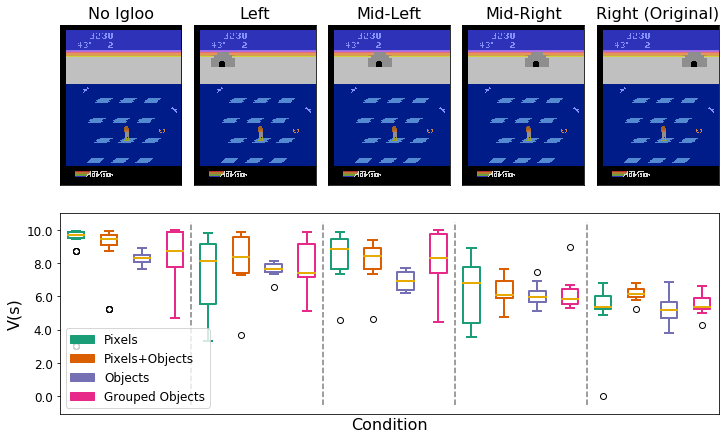

In [88]:
SRC_OBS_INDEX = IGLOO_BASE_STATE_INDEX
DST_OBS_INDEX = 5
IGLOO_CHANNEL_INDEX = 7

LOCATIONS = (
    (35, 22),
    (35, 52),
    (35, 82),
    (35, 112),
)


NUM_AFTER_STATES = 4
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Left', 'Mid-Left', 'Mid-Right', 'Right (Original)']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

# left
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, IGLOO_CHANNEL_INDEX, LOCATIONS[IDX:IDX + 1], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='No Igloo', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=igloo_base_state_observations,
                                            augment_all_frames=True)

# Mid-left
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, IGLOO_CHANNEL_INDEX, LOCATIONS[IDX:IDX + 1], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='No Igloo', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=igloo_base_state_observations,
                                            augment_all_frames=True)


# Mid-right
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, IGLOO_CHANNEL_INDEX, LOCATIONS[IDX:IDX + 1], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='No Igloo', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=igloo_base_state_observations,
                                            augment_all_frames=True)
    
# Original
IDX = 3
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, IGLOO_CHANNEL_INDEX, LOCATIONS[IDX:IDX + 1], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='No Igloo', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=igloo_base_state_observations,
                                            augment_all_frames=True)
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

values_ax.set_yticklabels(values_ax.get_yticks(), fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

# save('alien_panel_smaller_fonts.pdf')

plt.show()

# One more attempt, from a dire situation, moving the next set of floes around

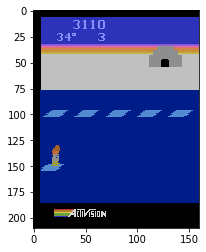

In [213]:
MOVING_BASE_STATE_INDEX = 730
OCEAN_ROW_RANGE = slice(77, 186)
OCEAN_COL_RANGE = slice(7, None)
MOVING_PLAYER_AND_FLOE_ROW_RANGE = slice(130, 155)
MOVING_PLAYER_AND_FLOE_COL_RANGE = slice(8, 30)

moving_player_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, 
                                                      MOVING_PLAYER_AND_FLOE_ROW_RANGE, 
                                                      MOVING_PLAYER_AND_FLOE_COL_RANGE]
MOVING_FLOE_ROW_RANGE = slice(96, 103)
MOVING_FLOE_COL_RANGE = slice(102, 126)

top_row_floe_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, MOVING_FLOE_ROW_RANGE, MOVING_FLOE_COL_RANGE]


moving_base_state = np.copy(sample_full_color_observations[MOVING_BASE_STATE_INDEX])
moving_base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = second_base_state[111, -1]
moving_base_state[MOVING_PLAYER_AND_FLOE_ROW_RANGE, MOVING_PLAYER_AND_FLOE_COL_RANGE] = moving_player_sprite

TOP_ROW_FLOE_STARTS = range(10, 150, 30)
for start in TOP_ROW_FLOE_STARTS:
    dst_col_slice = slice(start, start + MOVING_FLOE_COL_RANGE.stop - MOVING_FLOE_COL_RANGE.start)
    moving_base_state[MOVING_FLOE_ROW_RANGE, dst_col_slice] = top_row_floe_sprite

moving_base_state_observations = np.tile(moving_base_state, (10, 1, 1, 1))

plt.imshow(moving_base_state_observations[0])

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.704, median = 3.115 | After mean = 3.988, median = 3.904 
For model Pixels+Objects | Before mean = 4.620, median = 4.290 | After mean = 4.397, median = 4.662 
For model Objects | Before mean = 4.252, median = 3.751 | After mean = 3.575, median = 3.325 
For model Grouped Objects | Before mean = 4.846, median = 4.575 | After mean = 3.750, median = 2.780 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.704, median = 3.115 | After mean = 3.068, median = 3.010 
For model Pixels+Objects | Before mean = 4.620, median = 4.290 | After mean = 4.757, median = 4.368 
For model Objects | Before mean = 4.252, median = 3.751 | After mean = 4.473, median = 3.791 
For model Grouped Objects | Before mean = 4.846, median = 4.575 | After mean = 3.071, median = 2.463 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 3.704, median = 3.115 | After mean = 2.835, median = 2.628 
For model Pixels+Objects | Before mean = 4.620, median = 4.290 | After mean = 3.976, median = 3.200 
For model Objects | Before mean = 4.252, median = 3.751 | After mean = 5.210, median = 5.458 
For model Grouped Objects | Before mean = 4.846, median = 4.575 | After mean = 3.978, median = 4.458 


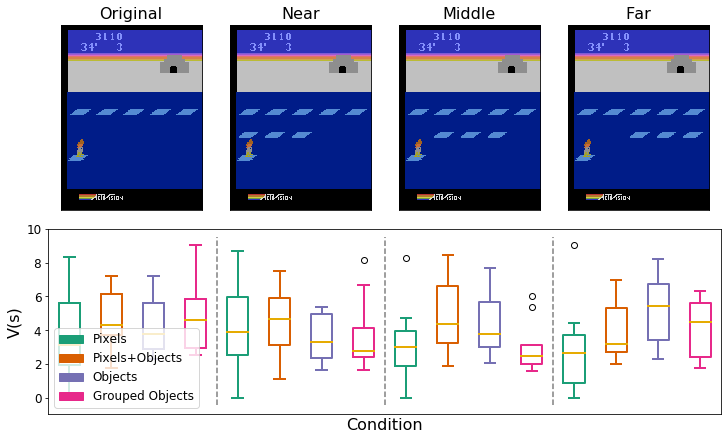

In [227]:
SRC_OBS_INDEX = MOVING_BASE_STATE_INDEX
DST_OBS_INDEX = 5
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 122
START_COL_LOCATIONS = (10, 40, 70)
FLOE_COL_LOCATION_INCREMENTS = (0, 30, 60)

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

# Near
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)

# Far only
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)


# Both
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

# save('alien_panel_smaller_fonts.pdf')

plt.show()

# And one more of those

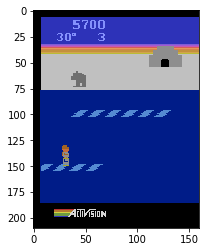

In [272]:
MOVING_BASE_STATE_INDEX = 1234
OCEAN_ROW_RANGE = slice(77, 186)
OCEAN_COL_RANGE = slice(7, None)
MOVING_PLAYER_AND_FLOE_ROW_RANGE = slice(130, 155)
MOVING_PLAYER_AND_FLOE_COL_RANGE = slice(8, 67)

moving_player_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, 
                                                      MOVING_PLAYER_AND_FLOE_ROW_RANGE, 
                                                      MOVING_PLAYER_AND_FLOE_COL_RANGE]
MOVING_FLOE_ROW_RANGE = slice(122, 129)
MOVING_FLOE_COL_RANGE = slice(15, 115)
top_row_floe_sprite = sample_full_color_observations[MOVING_BASE_STATE_INDEX, 
                                                     MOVING_FLOE_ROW_RANGE, 
                                                     MOVING_FLOE_COL_RANGE]

moving_base_state = np.copy(sample_full_color_observations[MOVING_BASE_STATE_INDEX])
moving_base_state[OCEAN_ROW_RANGE, OCEAN_COL_RANGE] = second_base_state[111, -1]
moving_base_state[MOVING_PLAYER_AND_FLOE_ROW_RANGE, MOVING_PLAYER_AND_FLOE_COL_RANGE] = moving_player_sprite

TOP_ROW_DST_ROW_RANGE = slice(96, 103)
TOP_ROW_DST_COL_RANGE = slice(35, 135)
moving_base_state[TOP_ROW_DST_ROW_RANGE, TOP_ROW_DST_COL_RANGE] = top_row_floe_sprite

moving_base_state_observations = np.tile(moving_base_state, (10, 1, 1, 1))

plt.imshow(moving_base_state_observations[0])

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 0.892, median = 0.502 | After mean = 0.709, median = 0.462 
For model Pixels+Objects | Before mean = 1.542, median = 1.192 | After mean = 1.360, median = 0.948 
For model Objects | Before mean = 1.379, median = 1.202 | After mean = 1.049, median = 0.992 
For model Grouped Objects | Before mean = 0.629, median = 0.342 | After mean = 0.511, median = 0.325 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 0.892, median = 0.502 | After mean = 0.757, median = 0.486 
For model Pixels+Objects | Before mean = 1.542, median = 1.192 | After mean = 1.431, median = 1.108 
For model Objects | Before mean = 1.379, median = 1.202 | After mean = 1.191, median = 1.071 
For model Grouped Objects | Before mean = 0.629, median = 0.342 | After mean = 0.420, median = 0.270 


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Pixels | Before mean = 0.892, median = 0.502 | After mean = 0.661, median = 0.473 
For model Pixels+Objects | Before mean = 1.542, median = 1.192 | After mean = 1.335, median = 0.898 
For model Objects | Before mean = 1.379, median = 1.202 | After mean = 1.008, median = 0.875 
For model Grouped Objects | Before mean = 0.629, median = 0.342 | After mean = 0.514, median = 0.464 


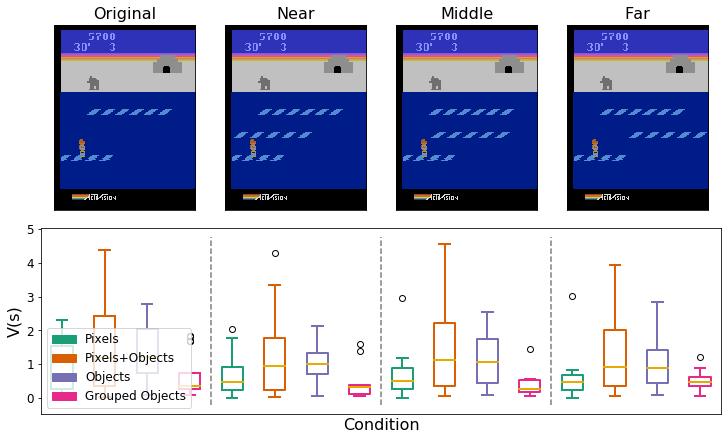

In [279]:
SRC_OBS_INDEX = MOVING_BASE_STATE_INDEX
DST_OBS_INDEX = 5
VISITED_FLOE_CHANNEL_INDEX = 5

FLOE_ROW_LOCATION = 122
START_COL_LOCATIONS = (10, 40, 70)
FLOE_COL_LOCATION_INCREMENTS = np.arange(5) * 18

LOCATION_SETS = [[(FLOE_ROW_LOCATION, start + inc) for inc in FLOE_COL_LOCATION_INCREMENTS] 
                 for start in START_COL_LOCATIONS]

NUM_AFTER_STATES = len(LOCATION_SETS)
    
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 1 + NUM_AFTER_STATES)
before_ax = fig.add_subplot(gs[0, 0])
after_axes = [fig.add_subplot(gs[0, i]) for i in range(1, 1 + NUM_AFTER_STATES)]
    
values_ax = fig.add_subplot(gs[1, :])
before_positions = np.arange(NUM_COMPARISON_MODELS)
after_positions = [np.arange(NUM_COMPARISON_MODELS) + (NUM_COMPARISON_MODELS * i) for i in range(1, 1 + NUM_AFTER_STATES)]

after_titles = ['Near', 'Middle', 'Far']

major_fontdict = dict(fontsize=16)
minor_fontdict = dict(fontsize=12)

# Near
IDX = 0
        
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)

# Far only
IDX = 1

do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)


# Both
IDX = 2
do_multiple_augmentation_comparison_single_plot(SRC_OBS_INDEX, DST_OBS_INDEX, VISITED_FLOE_CHANNEL_INDEX, LOCATION_SETS[IDX], 
                                            after_ax=after_axes[IDX], values_ax=values_ax, after_value_positions=after_positions[IDX],
                                            before_ax=before_ax, before_value_positions=before_positions, additional_boxplot_properties=None,
                                            before_title='Original', after_title=after_titles[IDX],
                                            major_fontdict=major_fontdict,
                                            minor_fontdict=minor_fontdict,
                                            object_index=0, object_pixels_and_mask=None,
                                            src_observations=sample_full_color_observations, dst_observations=moving_base_state_observations,
                                            augment_all_frames=True)
        

dashed_line_positions = np.arange(1, NUM_AFTER_STATES + 1) * NUM_COMPARISON_MODELS - 0.5
values_ax.vlines(dashed_line_positions, *values_ax.get_ylim(), colors='gray', linestyles='dashed')
        
values_ax.set_xticks([])
# values_ax.set_xticks(np.concatenate([before_positions] + after_positions))
# values_ax.set_xticklabels(list(FINAL_NAMES_FOR_TICKS) * 4, fontsize=12, rotation=0)

# print(values_ax.get_yticks())
# ytl = values_ax.get_yticklabels()
# print([l.get_text() for l in ytl])
# t = values_ax.get_yticklabels()[0]
# print([label.get_text() for label in values_ax.get_yticklabels()])
# values_ax.set_yticklabels([label.get_text() for label in values_ax.get_yticklabels()], fontsize=12)
values_ax.set_ylabel('V(s)', **major_fontdict)
values_ax.tick_params(axis='both', which='major', labelsize=12)

values_ax.set_xlabel('Condition', **major_fontdict)

legend_handles = []
for color, name in zip(DEFAULT_COLORS, FINAL_NAMES):
    legend_handles.append(patches.Patch(color=color, label=name))
    
plt.legend(handles=legend_handles, loc='lower left', **minor_fontdict)

# save('alien_panel_smaller_fonts.pdf')

plt.show()

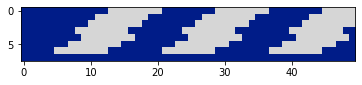

In [269]:
plt.imshow(sample_full_color_observations[1234, 96:104, 50:100])

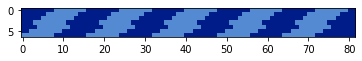

In [278]:
plt.imshow(sample_full_color_observations[1234, 122:129, 33:115])

-----

-----

# Older attempts at this

In [ ]:
INTERESTING_DST_INDICES = (94, 1112)

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INDEX = 875
CHANNEL_INDEX = 1

LOCATION_COLLECTIONS = (
    [(80, 12 + 12 * i) for i in range(12)],
    [(107, 12 + 12 * i) for i in range(6)],
    [(107, 6 + 12 * i) for i in range(8, 12)],
    [(135, 12 + 12 * i) for i in range(12)],
    [(160, 12 + 12 * i) for i in range(12)],
#     [(85, 12 + 12 * i) for i in range(12)],
)

NEW_LOCATIONS = []
for loc in LOCATION_COLLECTIONS:
    NEW_LOCATIONS.extend(loc)

do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS, plot_variance=True)

In [ ]:
SRC_OBS_INDEX = 1200
DST_OBS_INDEX = 2904
CHANNEL_INDEX = 7
# NEW_LOCATIONS = lambda loc: [(loc[0].start, loc[1].start + 10 * i) for i in range(12)]
NEW_LOCATIONS = None

do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS, plot_variance=True)

In [ ]:
SRC_OBS_INDEX = 450
CHANNEL_INDEX = 7
NEW_LOCATIONS = None

for DST_OBS_INDEX in INTERESTING_DST_INDICES:
    do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS)

# Existing good animal

In [ ]:
SRC_OBS_INDEX = 310
CHANNEL_INDEX = 6
NEW_LOCATIONS = None

START_LOC = (107, 12)

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[0], ):
    for row_loc_inc in (0, 25, 55):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS)

# Existing bad animal

In [ ]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 1
NEW_LOCATIONS = None

START_LOC = (107, 12)

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[0],):
    for row_loc_inc in (0, 25, 55):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS)

In [ ]:
SRC_OBS_INDEX = 1270
CHANNEL_INDEX = 1
NEW_LOCATIONS = None

START_LOC = (107, 12)

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[0],):
    for i, row_loc_inc in enumerate((0, 25, 55)):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS,
                                            save_name=f'invasion_of_the_crabs_{i}.pdf')

# Modified color

In [ ]:

SRC_OBS_INDEX = 2600

CHANNEL_INDEX = 7
NEW_LOCATIONS = None

for DST_OBS_INDEX in INTERESTING_DST_INDICES:
    do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS, hsv=(0.7, 0.8, None))

In [ ]:
SRC_OBS_INDEX = 310
CHANNEL_INDEX = 6

START_LOC = (107, 12)
row_loc_inc = 0

colors = ('green', 'blue', 'red')

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[1],):
    for i, hue in enumerate((None, 0.5, 0.9)):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, CHANNEL_INDEX, NEW_LOCATIONS,
                                            hsv=(hue, hue, None),
                                            save_name=f'what_about_{colors[i]}_fish.pdf')

# And with an alien

In [ ]:
alien_pixels_tensor = torch.tensor([[  0,   0,  52, 243,  52,   0,   0],
       [  0,   0, 243, 243, 243,   0,   0],
       [ 52, 243, 202, 243, 202, 243,  52],
       [243, 243, 148, 243, 148, 243, 243],
       [ 52, 243,  93, 243,  93, 243,  52],
       [243,   0,   0,   0,   0,   0, 243],
       [  0, 243,   0,   0,   0, 243,   0]], dtype=torch.float32, device=bad_animal_pixels_tensor.device) / 255

print(alien_pixels_tensor.mean())
print(bad_animal_pixels_tensor.mean(), fish_pixels_tensor.mean(), igloo_pixels_tensor.mean(), player_pixels_tensor.mean())

alien_mask_tensor = change_intensity(alien_pixels_tensor, multiplicative=2)
print(alien_mask_tensor.mean())
print(bad_animal_mask_tensor.mean(), fish_mask_tensor.mean(), igloo_mask_tensor.mean(), player_mask_tensor.mean())


alien_pixels_tensor_color = alien_pixels_tensor.repeat(3, 1, 1).permute(1, 2, 0)

water_color = torch.tensor([  0.,  28., 136.], device='cuda:0') / 255

black_indices = torch.all(alien_pixels_tensor_color == alien_pixels_tensor_color[0, 0], axis=2)
gray_indices = torch.all(alien_pixels_tensor_color == alien_pixels_tensor_color[0, 2], axis=2)

alien_pixels_tensor_color[black_indices + gray_indices] = water_color

alien_pixels_and_mask = (alien_pixels_tensor_color * 255, alien_mask_tensor)
plot_tensors(*alien_pixels_and_mask, norm=True)


In [ ]:
DEFAULT_MASK_NAMES

In [ ]:
SRC_OBS_INDEX = 325
# CHANNEL_INDEX = 1
NEW_LOCATIONS = None

START_LOC = (107, 12)
row_loc_inc = 0

for DST_OBS_INDEX in (INTERESTING_DST_INDICES[0],):
    for channel_index in (1, 4, 5, 6):
#     for row_loc_inc in (0, 25, 55):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 12 * i) for i in range(12)]
        do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, channel_index, NEW_LOCATIONS,
                                           object_pixels_and_mask=alien_pixels_and_mask)

In [ ]:
SRC_OBS_INDEX = 325
# CHANNEL_INDEX = 1
NEW_LOCATIONS = None

START_LOC = (146, 12)
row_loc_inc = 0

for DST_OBS_INDEX in (755,):
    for i, channel_index in enumerate((1, 5, 6)):
#     for row_loc_inc in (0, 25, 55):
        NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 10 * i) for i in range(8)]
        do_multiple_augmentation_comparison(SRC_OBS_INDEX, DST_OBS_INDEX, channel_index, NEW_LOCATIONS,
                                            object_pixels_and_mask=alien_pixels_and_mask,
                                            save_name=f'save_me_aliens_{DEFAULT_MASK_NAMES[channel_index + 1]}.pdf')

# B -- Same shape, new color
* New color in this case means new intensity since grayscale.
* Can probaly repeat the same experiments as above but just changing the pixels

# B.1 Another player, new color

In [ ]:
OBS_INDEX = 1449
CHANEL_INDEX = 0

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANEL_INDEX, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

lightened_player_pixels_tensor = change_intensity(player_pixels_tensor, multiplicative=3.0)

# plot_tensors(player_mask_tensor, player_pixels_tensor, lightened_player_pixels_tensor, norm=True)

NEW_PLAYER_LOCATION = (45, 45)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_player_pixels_tensor, player_mask_tensor, CHANEL_INDEX, [NEW_PLAYER_LOCATION])

evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

In [ ]:
OBS_INDEX = 1449
CHANEL_INDEX = 0

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANEL_INDEX, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

darkened_player_pixels_tensor = change_intensity(player_pixels_tensor, multiplicative=0.5)

# plot_tensors(player_mask_tensor, player_pixels_tensor, darkened_player_pixels_tensor, norm=True)

NEW_PLAYER_LOCATION = (45, 45)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_player_pixels_tensor, player_mask_tensor, CHANEL_INDEX, [NEW_PLAYER_LOCATION])

evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

# B.2 Adding a completed igloo to a state without a complete igloo

In [ ]:
SRC_OBS_INDEX = 2600
DST_OBS_INEX = 2100
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

lightened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=1.75)


# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 2600
DST_OBS_INEX = 2100
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

darkened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=0.5)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor, darkened_igloo_pixels_tensor, norm=True)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 450
DST_OBS_INEX = 94
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)
lightened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=1.75)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 450
DST_OBS_INEX = 94
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)
darkened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=0.5)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

# B.3 Adding many of a particular good animal

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 94
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor, lightened_fish_tensor, norm=True)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 94
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor, lightened_fish_tensor, norm=True)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 330
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, 5 + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 330
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, 5 + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

# B.4 Same but with a bad animal

In [ ]:
SRC_OBS_INDEX = 325
DST_OBS_INEX = 94
CHANNEL_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.5)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, bad_animal_loc[1].start + 5 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 325
DST_OBS_INEX = 94
CHANNEL_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.5)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, bad_animal_loc[1].start + 5 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

# NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

# NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 1112
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 1112
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

# C -- New shape (and presumably, new color)
* What happens if an alien from space invaders comes to play Frostbite?
* The current alien is a little bit larger than some existing other objects
* **TODO: do we use the same image as the mask and the pixels?** Let's make it a little bit later brighter, like the other images tend to be

In [ ]:
alien_pixels_tensor = torch.tensor([[  0,   0,  52, 243,  52,   0,   0],
       [  0,   0, 243, 243, 243,   0,   0],
       [ 52, 243, 202, 243, 202, 243,  52],
       [243, 243, 148, 243, 148, 243, 243],
       [ 52, 243,  93, 243,  93, 243,  52],
       [243,   0,   0,   0,   0,   0, 243],
       [  0, 243,   0,   0,   0, 243,   0]], dtype=torch.float32, device=bad_animal_pixels_tensor.device) / 255

print(alien_pixels_tensor.mean())
print(bad_animal_pixels_tensor.mean(), fish_pixels_tensor.mean(), igloo_pixels_tensor.mean(), player_pixels_tensor.mean())

alien_mask_tensor = change_intensity(alien_pixels_tensor, multiplicative=2)
print(alien_mask_tensor.mean())
print(bad_animal_mask_tensor.mean(), fish_mask_tensor.mean(), igloo_mask_tensor.mean(), player_mask_tensor.mean())

plot_tensors(alien_pixels_tensor, alien_mask_tensor, norm=True)

In [ ]:
small_alien_pixels_tensor = torch.tensor([[  0,  24, 243,  24,   0],
       [ 24, 243, 243, 243,  24],
       [243, 122, 243, 122, 243],
       [ 24,   0, 243,   0,  24],
       [ 44,   0,   0,   0,  44]], dtype=torch.float32, device=bad_animal_pixels_tensor.device) / 255
                                         
print(small_alien_pixels_tensor.mean())
print(bad_animal_pixels_tensor.mean(), fish_pixels_tensor.mean(), igloo_pixels_tensor.mean(), player_pixels_tensor.mean())

small_alien_mask_tensor = change_intensity(small_alien_pixels_tensor, multiplicative=2)
print(small_alien_mask_tensor.mean())
print(bad_animal_mask_tensor.mean(), fish_mask_tensor.mean(), igloo_mask_tensor.mean(), player_mask_tensor.mean())

darker_small_alien_tensor = change_intensity(small_alien_pixels_tensor, multiplicative=0.5)

plot_tensors(alien_pixels_tensor, alien_mask_tensor, small_alien_pixels_tensor, small_alien_mask_tensor, darker_small_alien_tensor, norm=True)

# C.1 Aliens as bad animals

In [ ]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 1
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((0, 10, 20), (0, 10, 20))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          small_alien_pixels_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.2 Darker alien as bad animal

In [ ]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 1
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((10, 20, 30), (10, 20, 30))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          darker_small_alien_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.3 Aliens as good animals

In [ ]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 6
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((0, 10, 20), (0, 10, 20))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          small_alien_pixels_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.4 Darker alien as good animal

In [ ]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 6
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((0, 10, 20), (0, 10, 20))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          darker_small_alien_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.5 Aliens as visited and unvisited ice floes? 

In [ ]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 6
START_LOC = (44, 10)

for name, channel_index in zip(('Unvisited Floes', 'Visited Floes'), (4, 5)):
    display(Markdown(f'## {name}'))
    
    for dst_index, row_loc_incs in zip((94, 1112),
                                       ((0, 10, 20), (0, 10, 20))):
        for row_loc_inc in row_loc_incs:

            NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

            baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
                make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                              darker_small_alien_tensor, small_alien_mask_tensor, channel_index, NEW_LOCATIONS)

            evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                     [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                      force_text=True)

            display(Markdown('----'))
    




# D Same as above but in aggregate

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INDEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 10 * i) for i in range(12)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

all_baseline_fish_augs = make_augmentation_per_model(baseline_fish_aug, all_baseline_models)
all_masks_and_pixels_fish_augs = make_augmentation_per_model(masks_and_pixels_fish_aug, all_masks_and_pixels_models)
all_masks_only_fish_augs = make_augmentation_per_model(masks_only_fish_aug, all_masks_only_models)


evaluate_multiple_models_single_augmented_state(sample_full_color_observations, DST_OBS_INDEX, 
                                                (all_baseline_fish_augs, all_masks_and_pixels_fish_augs, all_masks_only_fish_augs),
#                                                 key_actions=[5, 8, 9, 13, 16, 17],
                                                names=('Rainbow', 'With Objects', 'Only Objects'))
    

# A -- Same shape, same colors

# A.1 Additional player

In [ ]:
OBS_INDEX = 1449

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=0, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

NEW_PLAYER_LOCATION = (45, 45)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  player_pixels_tensor, player_mask_tensor, 0, [NEW_PLAYER_LOCATION])

evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

# A.2 Adding a completed igloo to a state without a complete igloo

In [ ]:
SRC_OBS_INDEX = 1200
DST_OBS_INEX = 2904
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 2600
DST_OBS_INEX = 2100
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 450
DST_OBS_INEX = 94
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

# A.3 Adding many of a particular good animal

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 94
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 13 * i) for i in range(10)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 330
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, 5 + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

# A.4 Same but with a bad animal

In [ ]:
SRC_OBS_INDEX = 325
DST_OBS_INEX = 94
CHANNEL_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, bad_animal_loc[1].start + 5 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

In [ ]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 1112
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

# Appendix: Plotting samples states to grab objects from

In [ ]:
plot_observations(sample_full_color_observations, 1230, 5, 5)

# Appendix: finding intriguing states to modify

In [47]:
result_sets = (baseline_model_results, masks_and_pixels_model_results, masks_only_model_results)

q_value_arrays = [np.array([x.cpu().numpy() for x in result_set.q_values])
                  for result_set in result_sets]
mean_q_value_arrays = [np.tile(q_vals.mean(1), (q_vals.shape[1], 1)).T
                       for q_vals in q_value_arrays]
msd_array = np.array([np.power(q - mean, 2).mean(1) for (q, mean)
                      in zip(q_value_arrays, mean_q_value_arrays)])

mean_q_values = np.array([q_vals.mean(1) for q_vals in q_value_arrays])

indices_without_extrema_q = np.argwhere(np.all(np.logical_and(mean_q_values > 3, mean_q_values < 7), axis=0))[:,0]

indices_with_all_models_msd = np.argwhere(np.all(msd_array > 1, axis=0))[:,0]
indices_with_two_models_msd = np.argwhere(np.sum(msd_array > 1, axis=0) > 0.5)[:,0]

interesting_indices = sorted(set(list(indices_without_extrema_q)).intersection(set(list(indices_with_two_models_msd))))
print(len(indices_without_extrema_q), len(indices_with_two_models_msd), len(interesting_indices))
print(interesting_indices)

s = 5
for i in range(len(interesting_indices) // s):
    plot_observations_by_indices(sample_full_color_observations, interesting_indices[i * s:(i + 1) * s])

NameError: name 'baseline_model_results' is not defined

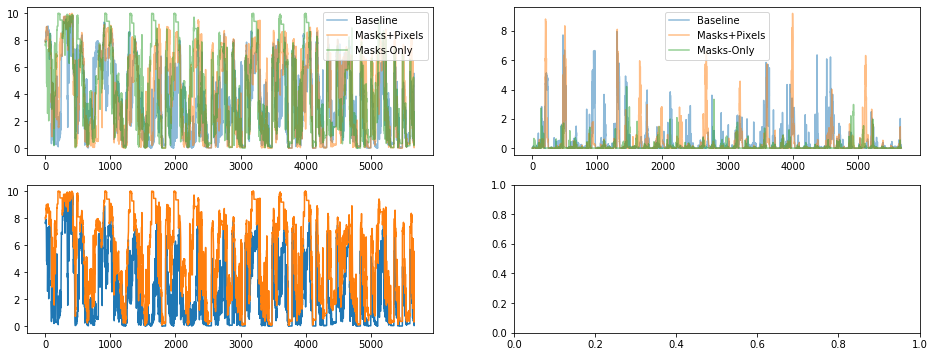

In [50]:


def plot_q_values(result_sets, names, **kwargs):
    plt.figure(figsize=(16, 6))

    q_value_arrays = [np.array([x.cpu().numpy() for x in result_set.q_values])
                         for result_set in result_sets]
    mean_q_value_arrays = [np.tile(q_vals.mean(1), (q_vals.shape[1], 1)).T
                           for q_vals in q_value_arrays]
    msd_arrays = [np.power(q - mean, 2).mean(1) for (q, mean)
                  in zip(q_value_arrays, mean_q_value_arrays)]
    
    mean_ax = plt.subplot(2, 2, 1)
    msd_ax = plt.subplot(2, 2, 2)
    
    for vals, msds, name in zip(q_value_arrays, msd_arrays, names):
        mean_ax.plot(vals.mean(1), label=name, **kwargs)
        msd_ax.plot(msds, label=name, **kwargs)
        
    mean_array = np.array([np.array([x.cpu().numpy() for x in res.q_values]).mean(1)
                           for res in result_sets])
    
    min_max_mean_ax = plt.subplot(2, 2, 3)
    min_max_mean_ax.plot(mean_array.min(0), label='Min')
    min_max_mean_ax.plot(mean_array.max(0), label='Max')
    
    mean_msd_ax = plt.subplot(2, 2, 4)
        
    mean_ax.legend(loc='best')
    msd_ax.legend(loc='best')
        
    plt.show()


plot_q_values((baseline_model_results, masks_and_pixels_model_results, masks_only_model_results),
              ('Baseline', 'Masks+Pixels', 'Masks-Only'), alpha=0.5)

In [165]:
DEFAULT_CM = plt.get_cmap('Dark2')


LEVEL_TRANSITIONS = (
    (175, 275),
    (450, 550),
    (895, 990),
    (1275, 1365),
    (1610, 1700),
    (1955, 2050),
    (2245, 2330),
    (2640, 2735),
    (3155, 3250),
    (3570, 3665),
    (3965, 4055),
    (4560, 4655),
    (5090, 5185)
    
)

DEATH_TRANSITIONS = (
    (4275, 4330),
    (4400, 4475),
    (4785, 4845),
    (4955, 5005),
    (5310, 5360),
    (5420, 5490),
    (5555, 5605)
) 


def plot_q_values_wide(result_sets, names, cmap=DEFAULT_CM, 
                       level_transitions=LEVEL_TRANSITIONS, death_transitions=DEATH_TRANSITIONS, 
                       level_color='blue', level_height=10.5, death_color='black', death_height=-0.5,
                       xlim=None, transition_kwargs=dict(lw=5, alpha=0.5),
                       **kwargs):
    plt.figure(figsize=(24, 6))

    q_value_arrays = [np.array([x.cpu().numpy() for x in result_set.q_values])
                         for result_set in result_sets]
    
    
    for i, (q_vals, name) in enumerate(zip(q_value_arrays, names)):
        ax = plt.subplot(1, 3, i + 1)
        ax.plot(q_vals, color=cmap(i), **kwargs)
        ax.set_title(name)
        
        for level in level_transitions:
            ax.plot(level, (level_height, level_height), color=level_color, **transition_kwargs)
            
        for death in death_transitions:
            ax.plot(death, (death_height, death_height), color=death_color, **transition_kwargs)
            
        if xlim is not None:
            ax.set_xlim(xlim)
        
    plt.show()



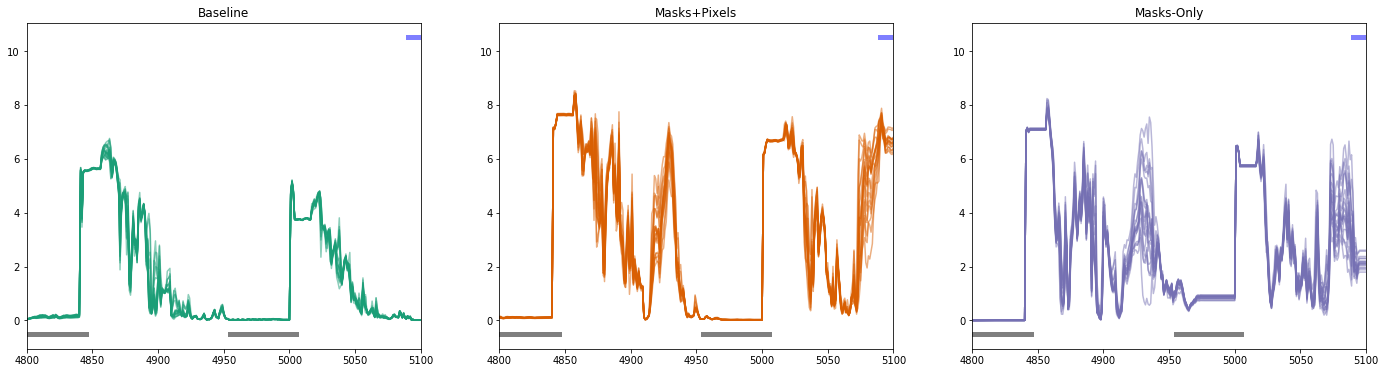

In [169]:
plot_q_values_wide((baseline_model_results, masks_and_pixels_model_results, masks_only_model_results),
              ('Baseline', 'Masks+Pixels', 'Masks-Only'), alpha=0.5, xlim=(4800, 5100))

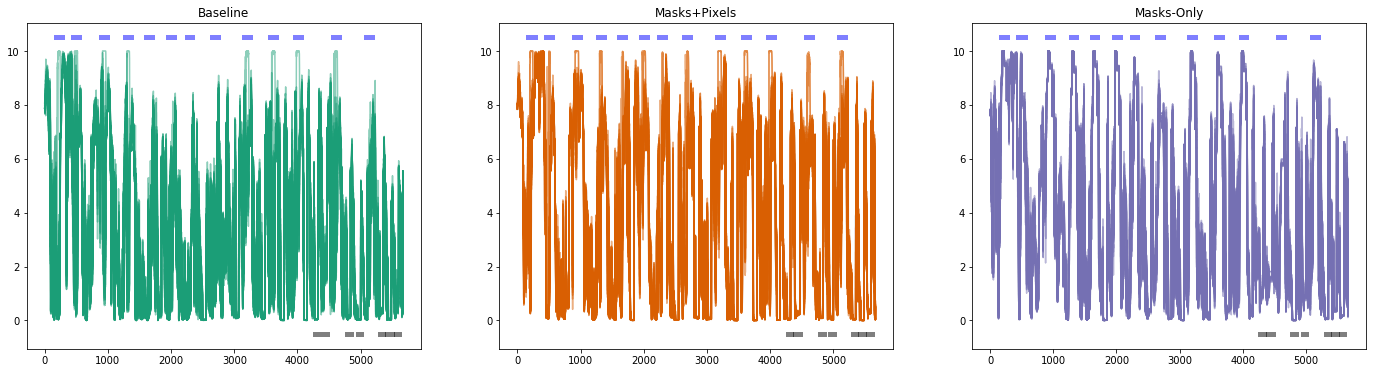

In [167]:
plot_q_values_wide((baseline_model_results, masks_and_pixels_model_results, masks_only_model_results),
              ('Baseline', 'Masks+Pixels', 'Masks-Only'), alpha=0.5)

In [173]:
np.sum(np.power(0.99, np.arange(100, 110)))

3.4999252952215305

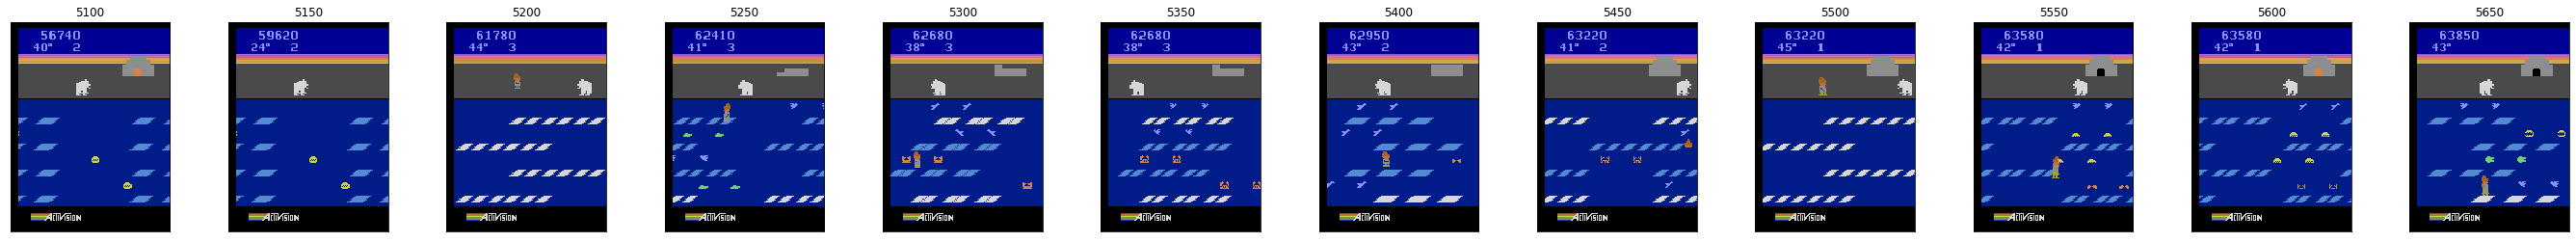

In [141]:
plot_observations_by_indices(sample_full_color_observations, range(5100, 5671, 50))

In [100]:
level_transitions = (
    (175, 275),
    (450, 550),
    (895, 990),
    (1275, 1365),
    (1610, 1700),
    (1955, 2050),
    (2245, 2330),
    (2640, 2735),
    (3155, 3250),
    (3570, 3665),
    (3965, 4055),
    (4560, 4655),
    (5090, 5185)
    
)

death_transitions = (
    (4275, 4330),
    (4400, 4475),
    (4785, 4845),
    (4955, 5005),
    (5310, 5360),
    (5420, 5490),
    (5555, 5605)
) 

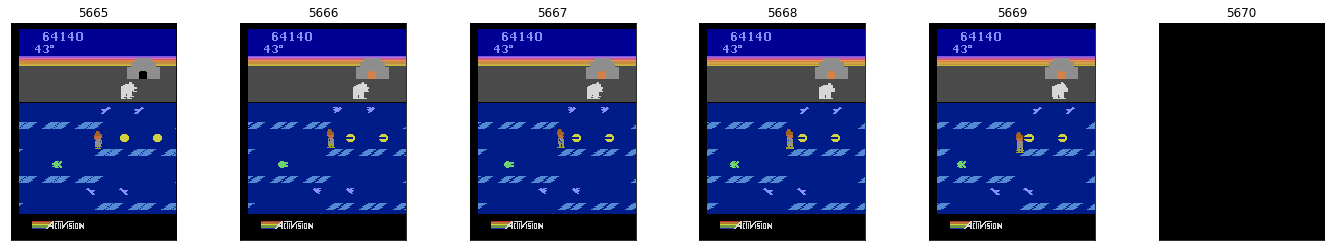

In [156]:
plot_observations_by_indices(sample_full_color_observations, range(5665, 5671, 1))

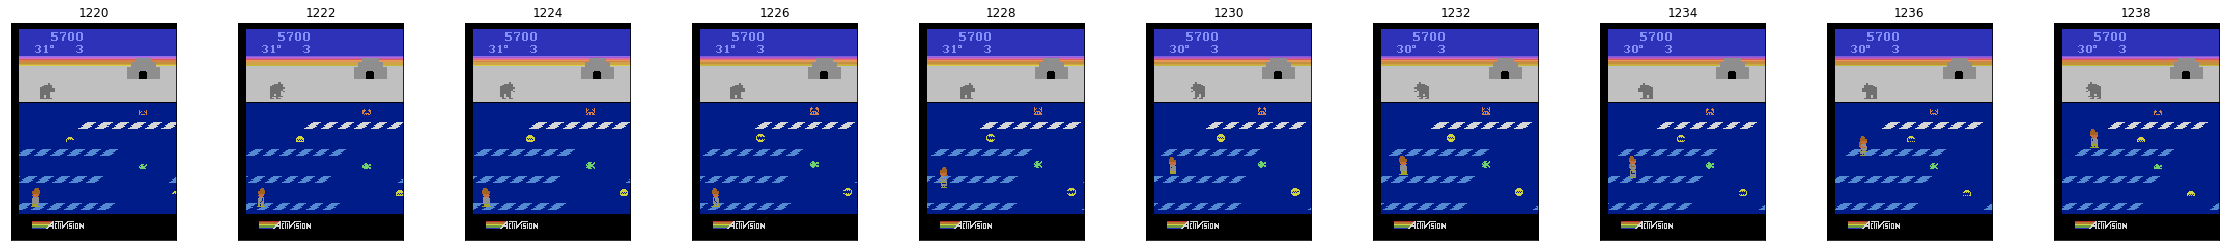

In [234]:
plot_observations_by_indices(sample_full_color_observations, range(1220, 1240, 2))

In [ ]:
h = masks_only_run.history()

In [ ]:
h['human_hours'][h['human_hours'].last_valid_index()]

In [ ]:
def human_hours_all_models(*run_urls, run_checker=lambda t: True):
    runs = [run for run in api.runs(run_urls[0]) if run_checker(run)]
    for url in run_urls[1:]:
        runs.extend([run for run in api.runs(url) if run_checker(run)])
    
    all_human_hours = []
    for run in runs:
        h = run.history()
        human_hours = h['human_hours'][h['human_hours'].last_valid_index()]
        all_human_hours.append(human_hours)
    
    all_human_hours = np.array(all_human_hours)
    print(np.min(all_human_hours), np.mean(all_human_hours), np.max(all_human_hours))


human_hours_all_models('augmented-frostbite/initial-experiments/runs', run_checker=lambda run: run.name.lower().startswith('baseline-rainbow-3'))

human_hours_all_models('augmented-frostbite/masks-and-pixels-fixed-resume/runs',
                       'augmented-frostbite/masks-and-pixels-replication/runs')

human_hours_all_models('augmented-frostbite/masks-only/runs',
                       'augmented-frostbite/masks-only-replication/runs')


In [ ]:
state = [observation_to_model(baseline_env, sample_full_color_observations[i])
         for i in range(100, 104)]
model_state = torch.cat(state, 0)
model_state.shape

In [ ]:
with torch.no_grad():
    probs = baseline_model.online_net(model_state.unsqueeze(0))
    mean = (probs * baseline_model.support).sum(2)
    var = (probs * (baseline_model.support - mean) ** 2).sum(2)
    mean = mean.squeeze(0)
    var = var.squeeze(0)
    print(mean)
    print(var)

In [ ]:
x = baseline_model.support.cpu().numpy()
for i in range(var.shape[0]):
    p = probs.squeeze(0)[i].cpu().numpy()
    dist = rv_discrete(values=(x, p))
    print(np.allclose(dist.var(), var[i].cpu().numpy()))

In [ ]:
!git pull

In [ ]:
dist.var()

In [ ]:
dist.stats??

In [ ]:
dist.mean()

In [ ]:
var.max(0)

In [ ]:
baseline_model.q_value_mean_variance(model_state)[0] == baseline_model.expected_q_values(model_state)